In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

class NFLCollisionAnalyzer:
    def __init__(self):
        self.collision_features = []
        self.injury_collisions = []
        
    def load_data(self):
        """Load all necessary datasets"""
        print("Loading datasets...")
        
        # Load video review (collision details)
        self.video_review = pd.read_csv('datasets/NFL-Punt-Analytics-Competition/video_review.csv')
        self.video_review.columns = self.video_review.columns.str.lower()
        
        # Load NGS motion data - ONLY REGULAR SEASON to avoid conflating different game types
        ngs_paths = [
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk7-12.csv', 
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk13-17.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk7-12.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk13-17.csv',
        ]
        
        def load_and_normalize(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            return df
        
        print("Loading NGS motion data...")
        self.motion_data = pd.concat([load_and_normalize(p) for p in ngs_paths], ignore_index=True)
        
        print("NGS columns:", list(self.motion_data.columns))
        print("Video review columns:", list(self.video_review.columns))
        
        # CRITICAL: Convert all key columns to float64 to match motion data format
        print("Converting data types to ensure matching...")
        
        # Motion data - ensure consistent types
        self.motion_data['gamekey'] = self.motion_data['gamekey'].astype('float64')
        self.motion_data['playid'] = self.motion_data['playid'].astype('float64')
        self.motion_data['gsisid'] = self.motion_data['gsisid'].astype('float64')
        self.motion_data['season_year'] = self.motion_data['season_year'].astype('int')
        
        # Video review - convert to match motion data types (handle text values)
        self.video_review['gamekey'] = self.video_review['gamekey'].astype('float64')
        self.video_review['playid'] = self.video_review['playid'].astype('float64')
        self.video_review['gsisid'] = self.video_review['gsisid'].astype('float64')
        
        # Handle partner GSISID - convert to numeric, non-numeric becomes NaN
        self.video_review['primary_partner_gsisid'] = pd.to_numeric(
            self.video_review['primary_partner_gsisid'], errors='coerce'
        )
        
        self.video_review['season_year'] = self.video_review['season_year'].astype('int')
        
        # Clean missing data
        self.motion_data.dropna(subset=['gsisid'], inplace=True)
        
        print(f"Loaded {len(self.motion_data)} motion records")
        print(f"Video review: {len(self.video_review)} injury cases")
        
        # Debug: Check play sizes (more than 22 is likely normal due to substitutions)
        print("\nChecking play sizes...")
        play_sizes = self.motion_data.groupby(['season_year', 'gamekey', 'playid'])['gsisid'].nunique()
        print(f"Play size statistics:")
        print(f"  Min players per play: {play_sizes.min()}")
        print(f"  Max players per play: {play_sizes.max()}")
        print(f"  Average players per play: {play_sizes.mean():.1f}")
        print(f"  Plays with exactly 22 players: {(play_sizes == 22).sum()}/{len(play_sizes)}")
        print("  Note: >22 players is normal due to substitutions and players entering/leaving field")
        
        # Verify data types match
        print("\nData type verification:")
        print(f"Motion data types: gamekey={self.motion_data['gamekey'].dtype}, playid={self.motion_data['playid'].dtype}, gsisid={self.motion_data['gsisid'].dtype}")
        print(f"Video review types: gamekey={self.video_review['gamekey'].dtype}, playid={self.video_review['playid'].dtype}, gsisid={self.video_review['gsisid'].dtype}")
        
        # Test first injury case
        if len(self.video_review) > 0:
            first_injury = self.video_review.iloc[0]
            print(f"\nTesting first injury case:")
            print(f"  Game: {first_injury['gamekey']}, Play: {first_injury['playid']}")
            print(f"  Injured: {first_injury['gsisid']}, Partner: {first_injury['primary_partner_gsisid']}")
            
            # Check if we can find the play
            test_play = self.motion_data[
                (self.motion_data['season_year'] == first_injury['season_year']) &
                (self.motion_data['gamekey'] == first_injury['gamekey']) &
                (self.motion_data['playid'] == first_injury['playid'])
            ]
            print(f"  Found {len(test_play)} motion records for this play")
            
            if len(test_play) > 0:
                players_in_play = test_play['gsisid'].unique()
                injured_found = first_injury['gsisid'] in players_in_play
                partner_found = first_injury['primary_partner_gsisid'] in players_in_play
                print(f"  Injured player found: {injured_found}")
                print(f"  Partner player found: {partner_found}")

    def analyze_collision_case(self, season, gamekey, playid, injured_player, partner_player):
        """Analyze a specific collision between two players"""
        
        print(f"\nAnalyzing collision: Season {season}, Game {gamekey}, Play {playid}")
        print(f"  Injured player: {injured_player} (type: {type(injured_player)})")
        print(f"  Collision partner: {partner_player} (type: {type(partner_player)})")
        
        # Convert to same types as motion data (float64)
        gamekey = float(gamekey)
        playid = float(playid)
        injured_player = float(injured_player)
        
        # Handle partner_player - might be NaN if it was 'Unclear'
        if pd.isna(partner_player):
            print("  ❌ Partner player is 'Unclear' - cannot analyze collision")
            return None
            
        partner_player = float(partner_player)
        
        print(f"  Converted - Injured: {injured_player}, Partner: {partner_player}")
        
        # Debug: Check what motion data exists for this play
        play_debug = self.motion_data[
            (self.motion_data['season_year'] == season) &
            (self.motion_data['gamekey'] == gamekey) &
            (self.motion_data['playid'] == playid)
        ]
        print(f"  Motion records for this play: {len(play_debug)}")
        if len(play_debug) > 0:
            print(f"  Players in this play: {play_debug['gsisid'].nunique()}")
            available_players = sorted(play_debug['gsisid'].unique())
            print(f"  Looking for injured: {injured_player} ({'✅' if injured_player in available_players else '❌'})")
            print(f"  Looking for partner: {partner_player} ({'✅' if partner_player in available_players else '❌'})")
        
        # Get motion data for both players with season filter
        play_motion = self.motion_data[
            (self.motion_data['season_year'] == season) &
            (self.motion_data['gamekey'] == gamekey) &
            (self.motion_data['playid'] == playid) &
            (self.motion_data['gsisid'].isin([injured_player, partner_player]))
        ].copy()
        
        if len(play_motion) == 0:
            print("  ❌ No motion data found for target players")
            return None
            
        # Sort and prepare data
        play_motion['time'] = pd.to_datetime(play_motion['time'])
        play_motion = play_motion.sort_values(['gsisid', 'time'])
        
        # Calculate relative time
        play_motion['seconds'] = play_motion.groupby('gsisid')['time'].transform(
            lambda x: (x - x.min()).dt.total_seconds()
        )
        
        # Separate the two players
        injured_motion = play_motion[play_motion['gsisid'] == injured_player].copy()
        partner_motion = play_motion[play_motion['gsisid'] == partner_player].copy()
        
        if len(injured_motion) == 0 or len(partner_motion) == 0:
            print("  ❌ Missing motion data for one or both players")
            print(f"    Injured player {injured_player}: {len(injured_motion)} records")
            print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
        
        if len(injured_motion) <3 or len(partner_motion) < 3:
            print("  ❌ insufficient motion data points for gradient calculations")
            print(f"    Injured player {injured_player}: {len(injured_motion)} records")
            print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
            
        print(f"  ✅ Motion records - Injured: {len(injured_motion)}, Partner: {len(partner_motion)}")
        
        # Calculate collision features
        collision_features = self.calculate_collision_features(injured_motion, partner_motion)
        
        return collision_features
    
    def calculate_collision_features(self, player1_motion, player2_motion):
        """Calculate collision-specific features from two players' movement data"""
        
        # Ensure both have time alignment
        # Find overlapping time period
        max_start_time = max(player1_motion['seconds'].min(), player2_motion['seconds'].min())
        min_end_time = min(player1_motion['seconds'].max(), player2_motion['seconds'].max())
        
        if max_start_time >= min_end_time:
            print("    ⚠️ No overlapping time period")
            return None
        
        # Interpolate positions to common time points
        common_times = np.arange(max_start_time, min_end_time, 0.1)  # 10Hz
        
        def interpolate_player_data(motion_data, times):
            interp_data = pd.DataFrame({'time': times})
            for col in ['x', 'y', 'dis', 'o', 'dir']:
                if col in motion_data.columns:
                    interp_data[col] = np.interp(times, motion_data['seconds'], motion_data[col])
            return interp_data
        
        p1_interp = interpolate_player_data(player1_motion, common_times)
        p2_interp = interpolate_player_data(player2_motion, common_times)
        
        # Calculate collision features
        features = {}
        
        # 1. Distance over time
        distances = np.sqrt((p1_interp['x'] - p2_interp['x'])**2 + 
                           (p1_interp['y'] - p2_interp['y'])**2)
        
        features['min_distance'] = distances.min()
        features['distance_at_start'] = distances.iloc[0] if len(distances) > 0 else np.nan
        features['distance_at_end'] = distances.iloc[-1] if len(distances) > 0 else np.nan
        features['avg_distance'] = distances.mean()
        
        # Find closest approach
        min_dist_idx = distances.idxmin()
        features['time_to_closest_approach'] = common_times[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 2. Relative velocities
        p1_vx = np.gradient(p1_interp['x']) / 0.1
        p1_vy = np.gradient(p1_interp['y']) / 0.1
        p2_vx = np.gradient(p2_interp['x']) / 0.1
        p2_vy = np.gradient(p2_interp['y']) / 0.1
        
        # Relative velocity (how fast they're approaching)
        rel_vx = p1_vx - p2_vx
        rel_vy = p1_vy - p2_vy
        relative_speed = np.sqrt(rel_vx**2 + rel_vy**2)
        
        features['max_relative_speed'] = np.nanmax(relative_speed)
        features['avg_relative_speed'] = np.nanmean(relative_speed)
        features['relative_speed_at_closest'] = relative_speed[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 3. Approach angles
        if not pd.isna(min_dist_idx):
            # Vector from player 2 to player 1 at closest approach
            dx = p1_interp['x'].iloc[min_dist_idx] - p2_interp['x'].iloc[min_dist_idx]
            dy = p1_interp['y'].iloc[min_dist_idx] - p2_interp['y'].iloc[min_dist_idx]
            collision_angle = np.degrees(np.arctan2(dy, dx))
            
            # Player orientations at collision
            p1_orientation = p1_interp['o'].iloc[min_dist_idx]
            p2_orientation = p2_interp['o'].iloc[min_dist_idx]
            
            features['collision_angle'] = collision_angle
            features['p1_orientation_at_collision'] = p1_orientation
            features['p2_orientation_at_collision'] = p2_orientation
            
            # Angle differences (head-on vs side collision)
            features['p1_angle_diff'] = abs(p1_orientation - collision_angle)
            features['p2_angle_diff'] = abs(p2_orientation - collision_angle)
        
        # 4. Speed characteristics
        features['p1_max_speed'] = p1_interp['dis'].max()
        features['p2_max_speed'] = p2_interp['dis'].max()
        features['p1_avg_speed'] = p1_interp['dis'].mean()
        features['p2_avg_speed'] = p2_interp['dis'].mean()
        
        if not pd.isna(min_dist_idx):
            features['p1_speed_at_collision'] = p1_interp['dis'].iloc[min_dist_idx]
            features['p2_speed_at_collision'] = p2_interp['dis'].iloc[min_dist_idx]
        
        # 5. Acceleration patterns leading up to collision
        if not pd.isna(min_dist_idx) and min_dist_idx > 5:  # Need some history
            pre_collision_indices = max(0, min_dist_idx - 10), min_dist_idx
            
            p1_pre_speeds = p1_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            p2_pre_speeds = p2_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            
            if len(p1_pre_speeds) > 1:
                features['p1_acceleration_before_collision'] = np.gradient(p1_pre_speeds).mean()
                features['p2_acceleration_before_collision'] = np.gradient(p2_pre_speeds).mean()
        
        # 6. Time-based features
        features['play_duration'] = len(common_times) * 0.1
        features['collision_timing'] = features['time_to_closest_approach'] / features['play_duration'] if features['play_duration'] > 0 else np.nan
        
        return features
    
    def analyze_all_injury_collisions(self):
        """Analyze all injury cases with known collision partners"""
        
        print("="*60)
        print("ANALYZING ALL INJURY COLLISIONS")
        print("="*60)
        
        injury_collision_features = []
        
        for _, injury in self.video_review.iterrows():
            season = injury['season_year']
            gamekey = injury['gamekey']
            playid = injury['playid']
            injured_player = injury['gsisid']
            
            # Skip if no collision partner
            if pd.isna(injury.get('primary_partner_gsisid')):
                print(f"Skipping injury without collision partner: Game {gamekey}, Play {playid}")
                continue
                
            partner_player = injury['primary_partner_gsisid']
            impact_type = injury.get('primary_impact_type', 'Unknown')
            
            print(f"\nCase: Game {gamekey}, Play {playid}")
            print(f"  Impact: {impact_type}")
            print(f"  Injured: {injured_player} vs Partner: {partner_player}")
            
            # Analyze this collision
            collision_features = self.analyze_collision_case(
                season, gamekey, playid, injured_player, partner_player
            )
            
            if collision_features is not None:
                # Add metadata
                collision_features['season_year'] = season
                collision_features['gamekey'] = gamekey
                collision_features['playid'] = playid
                collision_features['injured_player'] = injured_player
                collision_features['partner_player'] = partner_player
                collision_features['impact_type'] = impact_type
                collision_features['player_activity'] = injury.get('player_activity_derived', 'Unknown')
                collision_features['partner_activity'] = injury.get('primary_partner_activity_derived', 'Unknown')
                collision_features['friendly_fire'] = injury.get('friendly_fire', 'Unknown')
                collision_features['is_injury'] = 1
                
                injury_collision_features.append(collision_features)
                print(f"  ✅ Extracted collision features")
            else:
                print(f"  ❌ Could not extract collision features")
        
        return pd.DataFrame(injury_collision_features)
    
    def sample_non_injury_collisions(self, num_samples=10000):
        """Sample non-injury collisions for comparison"""
        
        print(f"\nSampling {num_samples} non-injury collisions for comparison...")
        
        # Get random plays that are NOT injury plays
        injury_plays = set()
        for _, injury in self.video_review.iterrows():
            injury_plays.add((injury['season_year'], injury['gamekey'], injury['playid']))
        
        # Sample random plays that are NOT injury plays
        all_plays = self.motion_data[['season_year', 'gamekey', 'playid']].drop_duplicates()
        non_injury_plays = all_plays[~all_plays.apply(
            lambda x: (x['season_year'], x['gamekey'], x['playid']) in injury_plays, axis=1
        )].sample(n=min(num_samples*5, len(all_plays)), random_state=42)
        
        non_injury_features = []
        
        for _, play in non_injury_plays.iterrows():
            if len(non_injury_features) >= num_samples:
                break
                
            # Get all players in this play
            play_players = self.motion_data[
                (self.motion_data['season_year'] == play['season_year']) &
                (self.motion_data['gamekey'] == play['gamekey']) &
                (self.motion_data['playid'] == play['playid'])
            ]['gsisid'].unique()
            
            if len(play_players) < 2:
                continue
                
            # Pick two random players to analyze their "collision"
            player1, player2 = np.random.choice(play_players, 2, replace=False)
            
            player1_data = self.motion_data[
                (self.motion_data['season_year'] == play['season_year']) &
                (self.motion_data['gamekey'] == play['gamekey']) &
                (self.motion_data['playid'] == play['playid']) &
                (self.motion_data['gsisid'] == player1)
            ]    
            
            player2_data = self.motion_data[
                (self.motion_data['season_year'] == play['season_year']) &
                (self.motion_data['gamekey'] == play['gamekey']) &
                (self.motion_data['playid'] == play['playid']) &
                (self.motion_data['gsisid'] == player2)
            ]

            if len(player1_data) < 3 or len(player2_data) < 3:
                continue

            collision_features = self.analyze_collision_case(
                play['season_year'], play['gamekey'], play['playid'], player1, player2
            )

            if collision_features is not None:
                # Add metadata
                collision_features['season_year'] = play['season_year']
                collision_features['gamekey'] = play['gamekey']
                collision_features['playid'] = play['playid']
                collision_features['injured_player'] = player1
                collision_features['partner_player'] = player2
                collision_features['impact_type'] = 'No injury'
                collision_features['is_injury'] = 0
                
                non_injury_features.append(collision_features)
        
        print(f"Sampled {len(non_injury_features)} non-injury collisions")
        return pd.DataFrame(non_injury_features)
    
    def compare_injury_vs_normal_collisions(self, injury_df, normal_df):
        """Compare collision characteristics between injury and normal plays"""
        
        print("="*60)
        print("INJURY vs NORMAL COLLISION COMPARISON")
        print("="*60)
        
        # Collision features to compare
        collision_metrics = [
            'min_distance', 'max_relative_speed', 'avg_relative_speed',
            'p1_max_speed', 'p2_max_speed', 'p1_speed_at_collision', 'p2_speed_at_collision',
            'collision_timing', 'p1_angle_diff', 'p2_angle_diff'
        ]
        
        print(f"Injury collisions: {len(injury_df)}")
        print(f"Normal collisions: {len(normal_df)}")
        
        print(f"\nCollision Feature Comparison:")
        print(f"{'Feature':<25} {'Injury Avg':<12} {'Normal Avg':<12} {'Ratio':<8} {'Significant?'}")
        print("-" * 70)
        
        significant_features = []
        
        for feature in collision_metrics:
            if feature in injury_df.columns and feature in normal_df.columns:
                injury_mean = injury_df[feature].mean()
                normal_mean = normal_df[feature].mean()
                ratio = injury_mean / normal_mean if normal_mean != 0 else np.inf
                
                # Simple significance test (t-test would be better)
                injury_std = injury_df[feature].std()
                normal_std = normal_df[feature].std()
                difference = abs(injury_mean - normal_mean)
                pooled_std = np.sqrt((injury_std**2 + normal_std**2) / 2)
                
                is_significant = difference > pooled_std  # Simple heuristic
                
                print(f"{feature:<25} {injury_mean:<12.3f} {normal_mean:<12.3f} {ratio:<8.2f} {'Yes' if is_significant else 'No'}")
                
                if is_significant:
                    significant_features.append((feature, ratio))
        
        print(f"\nMost Significant Differences:")
        significant_features.sort(key=lambda x: abs(x[1] - 1), reverse=True)
        for feature, ratio in significant_features[:5]:
            direction = "higher" if ratio > 1 else "lower"
            print(f"  {feature}: {ratio:.2f}x {direction} in injury collisions")
        
        return significant_features


def run_collision_analysis():
    """Main function to run the complete collision analysis"""
    
    analyzer = NFLCollisionAnalyzer()
    
    try:
        # Load data
        analyzer.load_data()
        
        # Analyze injury collisions
        injury_collisions = analyzer.analyze_all_injury_collisions()
        
        if len(injury_collisions) == 0:
            print("❌ No injury collisions found with motion data")
            # Return empty DataFrames instead of None
            return pd.DataFrame(), pd.DataFrame(), []
        
        print(f"\n✅ Successfully analyzed {len(injury_collisions)} injury collisions")
        
        # Sample normal collisions for comparison
        normal_collisions = analyzer.sample_non_injury_collisions(num_samples=len(injury_collisions)*3)
        
        # Compare injury vs normal
        significant_features = analyzer.compare_injury_vs_normal_collisions(injury_collisions, normal_collisions)
        
        # Save results
        injury_collisions.to_csv('scripts/punt_analytics/injury_collision_features.csv', index=False)
        normal_collisions.to_csv('scripts/punt_analytics/normal_collision_features.csv', index=False)
        
        print(f"\n🎯 COLLISION ANALYSIS COMPLETE!")
        print(f"Key insights will show whether:")
        print(f"  - Injury collisions have different approach patterns")
        print(f"  - Relative speeds/angles predict injury risk")
        print(f"  - Collision timing matters for injury occurrence")
        
        return injury_collisions, normal_collisions, significant_features
        
    except Exception as e:
        print(f"❌ Error in collision analysis: {e}")
        import traceback
        traceback.print_exc()
        # Return empty results on error
        return pd.DataFrame(), pd.DataFrame(), []


# Main execution
if __name__ == "__main__":
    # Run the collision analysis
    try:
        injury_df, normal_df, features = run_collision_analysis()
        
        if len(injury_df) > 0:
            print(f"\nResults:")
            print(f"- Injury collisions: {len(injury_df)}")
            print(f"- Normal collisions: {len(normal_df)}")
            print(f"- Significant features: {len(features)}")
        else:
            print("No collision data could be analyzed. Check your data files.")
            
    except Exception as e:
        print(f"Error running analysis: {e}")
        import traceback
        traceback.print_exc()

Loading datasets...
Loading NGS motion data...
NGS columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'time', 'x', 'y', 'dis', 'o', 'dir', 'event']
Video review columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'player_activity_derived', 'turnover_related', 'primary_impact_type', 'primary_partner_gsisid', 'primary_partner_activity_derived', 'friendly_fire']
Converting data types to ensure matching...
Loaded 60714735 motion records
Video review: 37 injury cases

Checking play sizes...
Play size statistics:
  Min players per play: 4
  Max players per play: 95
  Average players per play: 45.3
  Plays with exactly 22 players: 55/6049
  Note: >22 players is normal due to substitutions and players entering/leaving field

Data type verification:
Motion data types: gamekey=float64, playid=float64, gsisid=float64
Video review types: gamekey=float64, playid=float64, gsisid=float64

Testing first injury case:
  Game: 5.0, Play: 3129.0
  Injured: 31057.0, Partner: 32482.0
  Found 0 moti

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

class NFLCollisionAnalyzer:
    def __init__(self):
        self.collision_features = []
        self.injury_collisions = []
        
    def load_data(self):
        """Load all necessary datasets"""
        print("Loading datasets...")
        
        # Load video review (collision details)
        self.video_review = pd.read_csv('datasets/NFL-Punt-Analytics-Competition/video_review.csv')
        self.video_review.columns = self.video_review.columns.str.lower()
        
        # Load NGS motion data - ONLY REGULAR SEASON to avoid conflating different game types
        ngs_paths = [
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk7-12.csv', 
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk13-17.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk7-12.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk13-17.csv',
        ]
        
        def load_and_normalize(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            return df
        
        print("Loading NGS motion data...")
        self.motion_data = pd.concat([load_and_normalize(p) for p in ngs_paths], ignore_index=True)
        
        print("NGS columns:", list(self.motion_data.columns))
        print("Video review columns:", list(self.video_review.columns))
        
        # CRITICAL: Convert all key columns to float64 to match motion data format
        print("Converting data types to ensure matching...")
        
        # Motion data - ensure consistent types
        self.motion_data['gamekey'] = self.motion_data['gamekey'].astype('float64')
        self.motion_data['playid'] = self.motion_data['playid'].astype('float64')
        self.motion_data['gsisid'] = self.motion_data['gsisid'].astype('float64')
        self.motion_data['season_year'] = self.motion_data['season_year'].astype('int')
        
        # Video review - convert to match motion data types (handle text values)
        self.video_review['gamekey'] = self.video_review['gamekey'].astype('float64')
        self.video_review['playid'] = self.video_review['playid'].astype('float64')
        self.video_review['gsisid'] = self.video_review['gsisid'].astype('float64')
        
        # Handle partner GSISID - convert to numeric, non-numeric becomes NaN
        self.video_review['primary_partner_gsisid'] = pd.to_numeric(
            self.video_review['primary_partner_gsisid'], errors='coerce'
        )
        
        self.video_review['season_year'] = self.video_review['season_year'].astype('int')
        
        # Clean missing data
        self.motion_data.dropna(subset=['gsisid'], inplace=True)
        
        print(f"Loaded {len(self.motion_data)} motion records")
        print(f"Video review: {len(self.video_review)} injury cases")
        
        # Debug: Check play sizes (more than 22 is likely normal due to substitutions)
        print("\nChecking play sizes...")
        play_sizes = self.motion_data.groupby(['season_year', 'gamekey', 'playid'])['gsisid'].nunique()
        print(f"Play size statistics:")
        print(f"  Min players per play: {play_sizes.min()}")
        print(f"  Max players per play: {play_sizes.max()}")
        print(f"  Average players per play: {play_sizes.mean():.1f}")
        print(f"  Plays with exactly 22 players: {(play_sizes == 22).sum()}/{len(play_sizes)}")
        print("  Note: >22 players is normal due to substitutions and players entering/leaving field")
        
        # Verify data types match
        print("\nData type verification:")
        print(f"Motion data types: gamekey={self.motion_data['gamekey'].dtype}, playid={self.motion_data['playid'].dtype}, gsisid={self.motion_data['gsisid'].dtype}")
        print(f"Video review types: gamekey={self.video_review['gamekey'].dtype}, playid={self.video_review['playid'].dtype}, gsisid={self.video_review['gsisid'].dtype}")
        
        # Test first injury case
        if len(self.video_review) > 0:
            first_injury = self.video_review.iloc[0]
            print(f"\nTesting first injury case:")
            print(f"  Game: {first_injury['gamekey']}, Play: {first_injury['playid']}")
            print(f"  Injured: {first_injury['gsisid']}, Partner: {first_injury['primary_partner_gsisid']}")
            
            # Check if we can find the play
            test_play = self.motion_data[
                (self.motion_data['season_year'] == first_injury['season_year']) &
                (self.motion_data['gamekey'] == first_injury['gamekey']) &
                (self.motion_data['playid'] == first_injury['playid'])
            ]
            print(f"  Found {len(test_play)} motion records for this play")
            
            if len(test_play) > 0:
                players_in_play = test_play['gsisid'].unique()
                injured_found = first_injury['gsisid'] in players_in_play
                partner_found = first_injury['primary_partner_gsisid'] in players_in_play
                print(f"  Injured player found: {injured_found}")
                print(f"  Partner player found: {partner_found}")

    def analyze_collision_case(self, season, gamekey, playid, injured_player, partner_player):
        """Analyze a specific collision between two players"""
        
        print(f"\nAnalyzing collision: Season {season}, Game {gamekey}, Play {playid}")
        print(f"  Injured player: {injured_player} (type: {type(injured_player)})")
        print(f"  Collision partner: {partner_player} (type: {type(partner_player)})")
        
        # Convert to same types as motion data (float64)
        gamekey = float(gamekey)
        playid = float(playid)
        injured_player = float(injured_player)
        
        # Handle partner_player - might be NaN if it was 'Unclear'
        if pd.isna(partner_player):
            print("  ❌ Partner player is 'Unclear' - cannot analyze collision")
            return None
            
        partner_player = float(partner_player)
        
        print(f"  Converted - Injured: {injured_player}, Partner: {partner_player}")
        
        # Debug: Check what motion data exists for this play
        play_debug = self.motion_data[
            (self.motion_data['season_year'] == season) &
            (self.motion_data['gamekey'] == gamekey) &
            (self.motion_data['playid'] == playid)
        ]
        print(f"  Motion records for this play: {len(play_debug)}")
        if len(play_debug) > 0:
            print(f"  Players in this play: {play_debug['gsisid'].nunique()}")
            available_players = sorted(play_debug['gsisid'].unique())
            print(f"  Looking for injured: {injured_player} ({'✅' if injured_player in available_players else '❌'})")
            print(f"  Looking for partner: {partner_player} ({'✅' if partner_player in available_players else '❌'})")
        
        # Get motion data for both players with season filter
        play_motion = self.motion_data[
            (self.motion_data['season_year'] == season) &
            (self.motion_data['gamekey'] == gamekey) &
            (self.motion_data['playid'] == playid) &
            (self.motion_data['gsisid'].isin([injured_player, partner_player]))
        ].copy()
        
        if len(play_motion) == 0:
            print("  ❌ No motion data found for target players")
            return None
            
        # Sort and prepare data
        play_motion['time'] = pd.to_datetime(play_motion['time'])
        play_motion = play_motion.sort_values(['gsisid', 'time'])
        
        # Calculate relative time
        play_motion['seconds'] = play_motion.groupby('gsisid')['time'].transform(
            lambda x: (x - x.min()).dt.total_seconds()
        )
        
        # Separate the two players
        injured_motion = play_motion[play_motion['gsisid'] == injured_player].copy()
        partner_motion = play_motion[play_motion['gsisid'] == partner_player].copy()
        
        if len(injured_motion) == 0 or len(partner_motion) == 0:
            print("  ❌ Missing motion data for one or both players")
            print(f"    Injured player {injured_player}: {len(injured_motion)} records")
            print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
        
        if len(injured_motion) <3 or len(partner_motion) < 3:
            print("  ❌ insufficient motion data points for gradient calculations")
            print(f"    Injured player {injured_player}: {len(injured_motion)} records")
            print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
            
        print(f"  ✅ Motion records - Injured: {len(injured_motion)}, Partner: {len(partner_motion)}")
        
        # Calculate collision features
        collision_features = self.calculate_collision_features(injured_motion, partner_motion)
        
        return collision_features
    
    def calculate_collision_features(self, player1_motion, player2_motion):
        """Calculate collision-specific features from two players' movement data"""
        
        # Ensure both have time alignment
        # Find overlapping time period
        max_start_time = max(player1_motion['seconds'].min(), player2_motion['seconds'].min())
        min_end_time = min(player1_motion['seconds'].max(), player2_motion['seconds'].max())
        
        if max_start_time >= min_end_time:
            print("    ⚠️ No overlapping time period")
            return None
        
        # Interpolate positions to common time points
        common_times = np.arange(max_start_time, min_end_time, 0.1)  # 10Hz
        
        def interpolate_player_data(motion_data, times):
            interp_data = pd.DataFrame({'time': times})
            for col in ['x', 'y', 'dis', 'o', 'dir']:
                if col in motion_data.columns:
                    interp_data[col] = np.interp(times, motion_data['seconds'], motion_data[col])
            return interp_data
        
        p1_interp = interpolate_player_data(player1_motion, common_times)
        p2_interp = interpolate_player_data(player2_motion, common_times)
        
        # Calculate collision features
        features = {}
        
        # 1. Distance over time
        distances = np.sqrt((p1_interp['x'] - p2_interp['x'])**2 + 
                           (p1_interp['y'] - p2_interp['y'])**2)
        
        features['min_distance'] = distances.min()
        features['distance_at_start'] = distances.iloc[0] if len(distances) > 0 else np.nan
        features['distance_at_end'] = distances.iloc[-1] if len(distances) > 0 else np.nan
        features['avg_distance'] = distances.mean()
        
        # Find closest approach
        min_dist_idx = distances.idxmin()
        features['time_to_closest_approach'] = common_times[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 2. Relative velocities
        p1_vx = np.gradient(p1_interp['x']) / 0.1
        p1_vy = np.gradient(p1_interp['y']) / 0.1
        p2_vx = np.gradient(p2_interp['x']) / 0.1
        p2_vy = np.gradient(p2_interp['y']) / 0.1
        
        # Relative velocity (how fast they're approaching)
        rel_vx = p1_vx - p2_vx
        rel_vy = p1_vy - p2_vy
        relative_speed = np.sqrt(rel_vx**2 + rel_vy**2)
        
        features['max_relative_speed'] = np.nanmax(relative_speed)
        features['avg_relative_speed'] = np.nanmean(relative_speed)
        features['relative_speed_at_closest'] = relative_speed[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 3. Approach angles
        if not pd.isna(min_dist_idx):
            # Vector from player 2 to player 1 at closest approach
            dx = p1_interp['x'].iloc[min_dist_idx] - p2_interp['x'].iloc[min_dist_idx]
            dy = p1_interp['y'].iloc[min_dist_idx] - p2_interp['y'].iloc[min_dist_idx]
            collision_angle = np.degrees(np.arctan2(dy, dx))
            
            # Player orientations at collision
            p1_orientation = p1_interp['o'].iloc[min_dist_idx]
            p2_orientation = p2_interp['o'].iloc[min_dist_idx]
            
            features['collision_angle'] = collision_angle
            features['p1_orientation_at_collision'] = p1_orientation
            features['p2_orientation_at_collision'] = p2_orientation
            
            # Angle differences (head-on vs side collision)
            features['p1_angle_diff'] = abs(p1_orientation - collision_angle)
            features['p2_angle_diff'] = abs(p2_orientation - collision_angle)
        
        # 4. Speed characteristics
        features['p1_max_speed'] = p1_interp['dis'].max()
        features['p2_max_speed'] = p2_interp['dis'].max()
        features['p1_avg_speed'] = p1_interp['dis'].mean()
        features['p2_avg_speed'] = p2_interp['dis'].mean()
        
        if not pd.isna(min_dist_idx):
            features['p1_speed_at_collision'] = p1_interp['dis'].iloc[min_dist_idx]
            features['p2_speed_at_collision'] = p2_interp['dis'].iloc[min_dist_idx]
        
        # 5. Acceleration patterns leading up to collision
        if not pd.isna(min_dist_idx) and min_dist_idx > 5:  # Need some history
            pre_collision_indices = max(0, min_dist_idx - 10), min_dist_idx
            
            p1_pre_speeds = p1_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            p2_pre_speeds = p2_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            
            if len(p1_pre_speeds) > 1:
                features['p1_acceleration_before_collision'] = np.gradient(p1_pre_speeds).mean()
                features['p2_acceleration_before_collision'] = np.gradient(p2_pre_speeds).mean()
        
        # 6. Time-based features
        features['play_duration'] = len(common_times) * 0.1
        features['collision_timing'] = features['time_to_closest_approach'] / features['play_duration'] if features['play_duration'] > 0 else np.nan
        
        return features
    
    def analyze_all_injury_collisions(self):
        """Analyze all injury cases with known collision partners"""
        
        print("="*60)
        print("ANALYZING ALL INJURY COLLISIONS")
        print("="*60)
        
        injury_collision_features = []
        
        for _, injury in self.video_review.iterrows():
            season = injury['season_year']
            gamekey = injury['gamekey']
            playid = injury['playid']
            injured_player = injury['gsisid']
            
            # Skip if no collision partner
            if pd.isna(injury.get('primary_partner_gsisid')):
                print(f"Skipping injury without collision partner: Game {gamekey}, Play {playid}")
                continue
                
            partner_player = injury['primary_partner_gsisid']
            impact_type = injury.get('primary_impact_type', 'Unknown')
            
            print(f"\nCase: Game {gamekey}, Play {playid}")
            print(f"  Impact: {impact_type}")
            print(f"  Injured: {injured_player} vs Partner: {partner_player}")
            
            # Analyze this collision
            collision_features = self.analyze_collision_case(
                season, gamekey, playid, injured_player, partner_player
            )
            
            if collision_features is not None:
                # Add metadata
                collision_features['season_year'] = season
                collision_features['gamekey'] = gamekey
                collision_features['playid'] = playid
                collision_features['injured_player'] = injured_player
                collision_features['partner_player'] = partner_player
                collision_features['impact_type'] = impact_type
                collision_features['player_activity'] = injury.get('player_activity_derived', 'Unknown')
                collision_features['partner_activity'] = injury.get('primary_partner_activity_derived', 'Unknown')
                collision_features['friendly_fire'] = injury.get('friendly_fire', 'Unknown')
                collision_features['is_injury'] = 1
                
                injury_collision_features.append(collision_features)
                print(f"  ✅ Extracted collision features")
            else:
                print(f"  ❌ Could not extract collision features")
        
        return pd.DataFrame(injury_collision_features)
    
    def sample_non_injury_collisions(self, num_samples=10000):
        """Sample non-injury collisions for comparison"""
        
        print(f"\nSampling {num_samples} non-injury collisions for comparison...")
        
        # Get random plays that are NOT injury plays
        injury_plays = set()
        for _, injury in self.video_review.iterrows():
            injury_plays.add((injury['season_year'], injury['gamekey'], injury['playid']))
        
        # Sample random plays that are NOT injury plays
        all_plays = self.motion_data[['season_year', 'gamekey', 'playid']].drop_duplicates()
        non_injury_plays = all_plays[~all_plays.apply(
            lambda x: (x['season_year'], x['gamekey'], x['playid']) in injury_plays, axis=1
        )].sample(n=min(num_samples*5, len(all_plays)), random_state=42)
        
        print(f"Available non-injury plays to sample from: {len(non_injury_plays)}")
        
        non_injury_features = []
        
        # Add counters for debugging
        plays_processed = 0
        plays_too_few_players = 0
        plays_insufficient_data = 0
        analyze_failures = 0
        
        for _, play in non_injury_plays.iterrows():
            if len(non_injury_features) >= num_samples:
                break
            
            plays_processed += 1
            
            # Get all players in this play
            play_players = self.motion_data[
                (self.motion_data['season_year'] == play['season_year']) &
                (self.motion_data['gamekey'] == play['gamekey']) &
                (self.motion_data['playid'] == play['playid'])
            ]['gsisid'].unique()
            
            if len(play_players) < 2:
                plays_too_few_players += 1
                continue
            
            # Try multiple player pairs per play instead of just one
            max_attempts_per_play = 20  # Try up to 5 player pairs per play
            success_this_play = False
            
            for attempt in range(max_attempts_per_play):
                if success_this_play:
                    break
                    
                # Pick two random players to analyze their "collision"
                player1, player2 = np.random.choice(play_players, 2, replace=False)
                
                player1_data = self.motion_data[
                    (self.motion_data['season_year'] == play['season_year']) &
                    (self.motion_data['gamekey'] == play['gamekey']) &
                    (self.motion_data['playid'] == play['playid']) &
                    (self.motion_data['gsisid'] == player1)
                ]    
                
                player2_data = self.motion_data[
                    (self.motion_data['season_year'] == play['season_year']) &
                    (self.motion_data['gamekey'] == play['gamekey']) &
                    (self.motion_data['playid'] == play['playid']) &
                    (self.motion_data['gsisid'] == player2)
                ]

                if len(player1_data) < 3 or len(player2_data) < 3:
                    if attempt == 0:  # Only count once per play
                        plays_insufficient_data += 1
                    continue

                collision_features = self.analyze_collision_case(
                    play['season_year'], play['gamekey'], play['playid'], player1, player2
                )

                if collision_features is not None:
                    # Add metadata
                    collision_features['season_year'] = play['season_year']
                    collision_features['gamekey'] = play['gamekey']
                    collision_features['playid'] = play['playid']
                    collision_features['injured_player'] = player1
                    collision_features['partner_player'] = player2
                    collision_features['impact_type'] = 'No injury'
                    collision_features['is_injury'] = 0
                    
                    non_injury_features.append(collision_features)
                    success_this_play = True
                else:
                    if attempt == 0:  # Only count once per play
                        analyze_failures += 1
            
            # Progress update every 1000 plays
            if plays_processed % 1000 == 0:
                print(f"Progress: {plays_processed} plays processed, {len(non_injury_features)} successful samples")
        
        print(f"\nSampling Results:")
        print(f"  Plays processed: {plays_processed}")
        print(f"  Too few players: {plays_too_few_players}")
        print(f"  Insufficient data: {plays_insufficient_data}")
        print(f"  Analysis failures: {analyze_failures}")
        print(f"  Successful samples: {len(non_injury_features)}")
        print(f"  Success rate: {len(non_injury_features)/plays_processed:.1%}")
        
        return pd.DataFrame(non_injury_features)
    
    def compare_injury_vs_normal_collisions(self, injury_df, normal_df):
        """Compare collision characteristics between injury and normal plays"""
        
        print("="*60)
        print("INJURY vs NORMAL COLLISION COMPARISON")
        print("="*60)
        
        # Collision features to compare
        collision_metrics = [
            'min_distance', 'max_relative_speed', 'avg_relative_speed',
            'p1_max_speed', 'p2_max_speed', 'p1_speed_at_collision', 'p2_speed_at_collision',
            'collision_timing', 'p1_angle_diff', 'p2_angle_diff'
        ]
        
        print(f"Injury collisions: {len(injury_df)}")
        print(f"Normal collisions: {len(normal_df)}")
        
        print(f"\nCollision Feature Comparison:")
        print(f"{'Feature':<25} {'Injury Avg':<12} {'Normal Avg':<12} {'Ratio':<8} {'Significant?'}")
        print("-" * 70)
        
        significant_features = []
        
        for feature in collision_metrics:
            if feature in injury_df.columns and feature in normal_df.columns:
                injury_mean = injury_df[feature].mean()
                normal_mean = normal_df[feature].mean()
                ratio = injury_mean / normal_mean if normal_mean != 0 else np.inf
                
                # Simple significance test (t-test would be better)
                injury_std = injury_df[feature].std()
                normal_std = normal_df[feature].std()
                difference = abs(injury_mean - normal_mean)
                pooled_std = np.sqrt((injury_std**2 + normal_std**2) / 2)
                
                is_significant = difference > pooled_std  # Simple heuristic
                
                print(f"{feature:<25} {injury_mean:<12.3f} {normal_mean:<12.3f} {ratio:<8.2f} {'Yes' if is_significant else 'No'}")
                
                if is_significant:
                    significant_features.append((feature, ratio))
        
        print(f"\nMost Significant Differences:")
        significant_features.sort(key=lambda x: abs(x[1] - 1), reverse=True)
        for feature, ratio in significant_features[:5]:
            direction = "higher" if ratio > 1 else "lower"
            print(f"  {feature}: {ratio:.2f}x {direction} in injury collisions")
        
        return significant_features


def run_collision_analysis():
    """Main function to run the complete collision analysis"""
    
    analyzer = NFLCollisionAnalyzer()
    
    try:
        # Load data
        analyzer.load_data()
        
        # Analyze injury collisions
        injury_collisions = analyzer.analyze_all_injury_collisions()
        
        if len(injury_collisions) == 0:
            print("❌ No injury collisions found with motion data")
            # Return empty DataFrames instead of None
            return pd.DataFrame(), pd.DataFrame(), []
        
        print(f"\n✅ Successfully analyzed {len(injury_collisions)} injury collisions")
        
        # Sample normal collisions for comparison
        normal_collisions = analyzer.sample_non_injury_collisions(num_samples=len(injury_collisions)*3)
        
        # Compare injury vs normal
        significant_features = analyzer.compare_injury_vs_normal_collisions(injury_collisions, normal_collisions)
        
        # Save results
        injury_collisions.to_csv('scripts/punt_analytics/injury_collision_features.csv', index=False)
        normal_collisions.to_csv('scripts/punt_analytics/normal_collision_features.csv', index=False)
        
        print(f"\n🎯 COLLISION ANALYSIS COMPLETE!")
        print(f"Key insights will show whether:")
        print(f"  - Injury collisions have different approach patterns")
        print(f"  - Relative speeds/angles predict injury risk")
        print(f"  - Collision timing matters for injury occurrence")
        
        return injury_collisions, normal_collisions, significant_features
        
    except Exception as e:
        print(f"❌ Error in collision analysis: {e}")
        import traceback
        traceback.print_exc()
        # Return empty results on error
        return pd.DataFrame(), pd.DataFrame(), []


# Main execution
if __name__ == "__main__":
    # Run the collision analysis
    try:
        injury_df, normal_df, features = run_collision_analysis()
        
        if len(injury_df) > 0:
            print(f"\nResults:")
            print(f"- Injury collisions: {len(injury_df)}")
            print(f"- Normal collisions: {len(normal_df)}")
            print(f"- Significant features: {len(features)}")
        else:
            print("No collision data could be analyzed. Check your data files.")
            
    except Exception as e:
        print(f"Error running analysis: {e}")
        import traceback
        traceback.print_exc()

Loading datasets...
Loading NGS motion data...
NGS columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'time', 'x', 'y', 'dis', 'o', 'dir', 'event']
Video review columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'player_activity_derived', 'turnover_related', 'primary_impact_type', 'primary_partner_gsisid', 'primary_partner_activity_derived', 'friendly_fire']
Converting data types to ensure matching...
Loaded 60714735 motion records
Video review: 37 injury cases

Checking play sizes...
Play size statistics:
  Min players per play: 4
  Max players per play: 95
  Average players per play: 45.3
  Plays with exactly 22 players: 55/6049
  Note: >22 players is normal due to substitutions and players entering/leaving field

Data type verification:
Motion data types: gamekey=float64, playid=float64, gsisid=float64
Video review types: gamekey=float64, playid=float64, gsisid=float64

Testing first injury case:
  Game: 5.0, Play: 3129.0
  Injured: 31057.0, Partner: 32482.0
  Found 0 moti

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

class NFLCollisionAnalyzer:
    def __init__(self):
        self.collision_features = []
        self.injury_collisions = []
        
    def load_data(self):
        """Load all necessary datasets"""
        print("Loading datasets...")
        
        # Load video review (collision details)
        self.video_review = pd.read_csv('datasets/NFL-Punt-Analytics-Competition/video_review.csv')
        self.video_review.columns = self.video_review.columns.str.lower()
        
        # Load NGS motion data - ONLY REGULAR SEASON to avoid conflating different game types
        ngs_paths = [
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk7-12.csv', 
            'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk13-17.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-pre.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-post.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk1-6.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk7-12.csv',
            'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk13-17.csv',
        ]
        
        def load_and_normalize(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            return df
        
        print("Loading NGS motion data...")
        self.motion_data = pd.concat([load_and_normalize(p) for p in ngs_paths], ignore_index=True)
        
        print("NGS columns:", list(self.motion_data.columns))
        print("Video review columns:", list(self.video_review.columns))
        
        # CRITICAL: Convert all key columns to float64 to match motion data format
        print("Converting data types to ensure matching...")
        
        # Motion data - ensure consistent types
        self.motion_data['gamekey'] = self.motion_data['gamekey'].astype('float64')
        self.motion_data['playid'] = self.motion_data['playid'].astype('float64')
        self.motion_data['gsisid'] = self.motion_data['gsisid'].astype('float64')
        self.motion_data['season_year'] = self.motion_data['season_year'].astype('int')
        
        # Video review - convert to match motion data types (handle text values)
        self.video_review['gamekey'] = self.video_review['gamekey'].astype('float64')
        self.video_review['playid'] = self.video_review['playid'].astype('float64')
        self.video_review['gsisid'] = self.video_review['gsisid'].astype('float64')
        
        # Handle partner GSISID - convert to numeric, non-numeric becomes NaN
        self.video_review['primary_partner_gsisid'] = pd.to_numeric(
            self.video_review['primary_partner_gsisid'], errors='coerce'
        )
        
        self.video_review['season_year'] = self.video_review['season_year'].astype('int')
        
        # Clean missing data
        self.motion_data.dropna(subset=['gsisid'], inplace=True)
        
        print(f"Loaded {len(self.motion_data)} motion records")
        print(f"Video review: {len(self.video_review)} injury cases")
        
        # Debug: Check play sizes (more than 22 is likely normal due to substitutions)
        print("\nChecking play sizes...")
        play_sizes = self.motion_data.groupby(['season_year', 'gamekey', 'playid'])['gsisid'].nunique()
        print(f"Play size statistics:")
        print(f"  Min players per play: {play_sizes.min()}")
        print(f"  Max players per play: {play_sizes.max()}")
        print(f"  Average players per play: {play_sizes.mean():.1f}")
        print(f"  Plays with exactly 22 players: {(play_sizes == 22).sum()}/{len(play_sizes)}")
        print("  Note: >22 players is normal due to substitutions and players entering/leaving field")
        
        # Verify data types match
        print("\nData type verification:")
        print(f"Motion data types: gamekey={self.motion_data['gamekey'].dtype}, playid={self.motion_data['playid'].dtype}, gsisid={self.motion_data['gsisid'].dtype}")
        print(f"Video review types: gamekey={self.video_review['gamekey'].dtype}, playid={self.video_review['playid'].dtype}, gsisid={self.video_review['gsisid'].dtype}")
        
        # Test first injury case
        if len(self.video_review) > 0:
            first_injury = self.video_review.iloc[0]
            print(f"\nTesting first injury case:")
            print(f"  Game: {first_injury['gamekey']}, Play: {first_injury['playid']}")
            print(f"  Injured: {first_injury['gsisid']}, Partner: {first_injury['primary_partner_gsisid']}")
            
            # Check if we can find the play
            test_play = self.motion_data[
                (self.motion_data['season_year'] == first_injury['season_year']) &
                (self.motion_data['gamekey'] == first_injury['gamekey']) &
                (self.motion_data['playid'] == first_injury['playid'])
            ]
            print(f"  Found {len(test_play)} motion records for this play")
            
            if len(test_play) > 0:
                players_in_play = test_play['gsisid'].unique()
                injured_found = first_injury['gsisid'] in players_in_play
                partner_found = first_injury['primary_partner_gsisid'] in players_in_play
                print(f"  Injured player found: {injured_found}")
                print(f"  Partner player found: {partner_found}")

    def analyze_collision_case(self, season, gamekey, playid, injured_player, partner_player, verbose=False):
        """Analyze a specific collision between two players"""
        
        if verbose:
            print(f"\nAnalyzing collision: Season {season}, Game {gamekey}, Play {playid}")
            print(f"  Injured player: {injured_player} (type: {type(injured_player)})")
            print(f"  Collision partner: {partner_player} (type: {type(partner_player)})")
        
        # Convert to same types as motion data (float64)
        gamekey = float(gamekey)
        playid = float(playid)
        injured_player = float(injured_player)
        
        # Handle partner_player - might be NaN if it was 'Unclear'
        if pd.isna(partner_player):
            if verbose:
                print("  ❌ Partner player is 'Unclear' - cannot analyze collision")
            return None
            
        partner_player = float(partner_player)
        
        if verbose:
            print(f"  Converted - Injured: {injured_player}, Partner: {partner_player}")
        
        # Get motion data for both players with season filter
        play_motion = self.motion_data[
            (self.motion_data['season_year'] == season) &
            (self.motion_data['gamekey'] == gamekey) &
            (self.motion_data['playid'] == playid) &
            (self.motion_data['gsisid'].isin([injured_player, partner_player]))
        ].copy()
        
        if len(play_motion) == 0:
            if verbose:
                print("  ❌ No motion data found for target players")
            return None
            
        # Sort and prepare data
        play_motion['time'] = pd.to_datetime(play_motion['time'])
        play_motion = play_motion.sort_values(['gsisid', 'time'])
        
        # Calculate relative time
        play_motion['seconds'] = play_motion.groupby('gsisid')['time'].transform(
            lambda x: (x - x.min()).dt.total_seconds()
        )
        
        # Separate the two players
        injured_motion = play_motion[play_motion['gsisid'] == injured_player].copy()
        partner_motion = play_motion[play_motion['gsisid'] == partner_player].copy()
        
        if len(injured_motion) == 0 or len(partner_motion) == 0:
            if verbose:
                print("  ❌ Missing motion data for one or both players")
                print(f"    Injured player {injured_player}: {len(injured_motion)} records")
                print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
        
        if len(injured_motion) < 3 or len(partner_motion) < 3:
            if verbose:
                print("  ❌ insufficient motion data points for gradient calculations")
                print(f"    Injured player {injured_player}: {len(injured_motion)} records")
                print(f"    Partner player {partner_player}: {len(partner_motion)} records")
            return None
            
        if verbose:
            print(f"  ✅ Motion records - Injured: {len(injured_motion)}, Partner: {len(partner_motion)}")
        
        # Calculate collision features
        collision_features = self.calculate_collision_features(injured_motion, partner_motion)
        
        return collision_features
    
    def calculate_collision_features(self, player1_motion, player2_motion):
        """Calculate collision-specific features from two players' movement data"""
        
        # Ensure both have time alignment
        # Find overlapping time period
        max_start_time = max(player1_motion['seconds'].min(), player2_motion['seconds'].min())
        min_end_time = min(player1_motion['seconds'].max(), player2_motion['seconds'].max())
        
        if max_start_time >= min_end_time:
            return None
        
        # Interpolate positions to common time points
        common_times = np.arange(max_start_time, min_end_time, 0.1)  # 10Hz
        
        def interpolate_player_data(motion_data, times):
            interp_data = pd.DataFrame({'time': times})
            for col in ['x', 'y', 'dis', 'o', 'dir']:
                if col in motion_data.columns:
                    interp_data[col] = np.interp(times, motion_data['seconds'], motion_data[col])
            return interp_data
        
        p1_interp = interpolate_player_data(player1_motion, common_times)
        p2_interp = interpolate_player_data(player2_motion, common_times)
        
        # Calculate collision features
        features = {}
        
        # 1. Distance over time
        distances = np.sqrt((p1_interp['x'] - p2_interp['x'])**2 + 
                           (p1_interp['y'] - p2_interp['y'])**2)
        
        features['min_distance'] = distances.min()
        features['distance_at_start'] = distances.iloc[0] if len(distances) > 0 else np.nan
        features['distance_at_end'] = distances.iloc[-1] if len(distances) > 0 else np.nan
        features['avg_distance'] = distances.mean()
        
        # Find closest approach
        min_dist_idx = distances.idxmin()
        features['time_to_closest_approach'] = common_times[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 2. Relative velocities
        p1_vx = np.gradient(p1_interp['x']) / 0.1
        p1_vy = np.gradient(p1_interp['y']) / 0.1
        p2_vx = np.gradient(p2_interp['x']) / 0.1
        p2_vy = np.gradient(p2_interp['y']) / 0.1
        
        # Relative velocity (how fast they're approaching)
        rel_vx = p1_vx - p2_vx
        rel_vy = p1_vy - p2_vy
        relative_speed = np.sqrt(rel_vx**2 + rel_vy**2)
        
        features['max_relative_speed'] = np.nanmax(relative_speed)
        features['avg_relative_speed'] = np.nanmean(relative_speed)
        features['relative_speed_at_closest'] = relative_speed[min_dist_idx] if not pd.isna(min_dist_idx) else np.nan
        
        # 3. Approach angles
        if not pd.isna(min_dist_idx):
            # Vector from player 2 to player 1 at closest approach
            dx = p1_interp['x'].iloc[min_dist_idx] - p2_interp['x'].iloc[min_dist_idx]
            dy = p1_interp['y'].iloc[min_dist_idx] - p2_interp['y'].iloc[min_dist_idx]
            collision_angle = np.degrees(np.arctan2(dy, dx))
            
            # Player orientations at collision
            p1_orientation = p1_interp['o'].iloc[min_dist_idx]
            p2_orientation = p2_interp['o'].iloc[min_dist_idx]
            
            features['collision_angle'] = collision_angle
            features['p1_orientation_at_collision'] = p1_orientation
            features['p2_orientation_at_collision'] = p2_orientation
            
            # Angle differences (head-on vs side collision)
            features['p1_angle_diff'] = abs(p1_orientation - collision_angle)
            features['p2_angle_diff'] = abs(p2_orientation - collision_angle)
        
        # 4. Speed characteristics
        features['p1_max_speed'] = p1_interp['dis'].max()
        features['p2_max_speed'] = p2_interp['dis'].max()
        features['p1_avg_speed'] = p1_interp['dis'].mean()
        features['p2_avg_speed'] = p2_interp['dis'].mean()
        
        if not pd.isna(min_dist_idx):
            features['p1_speed_at_collision'] = p1_interp['dis'].iloc[min_dist_idx]
            features['p2_speed_at_collision'] = p2_interp['dis'].iloc[min_dist_idx]
        
        # 5. Acceleration patterns leading up to collision
        if not pd.isna(min_dist_idx) and min_dist_idx > 5:  # Need some history
            pre_collision_indices = max(0, min_dist_idx - 10), min_dist_idx
            
            p1_pre_speeds = p1_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            p2_pre_speeds = p2_interp['dis'].iloc[pre_collision_indices[0]:pre_collision_indices[1]]
            
            if len(p1_pre_speeds) > 1:
                features['p1_acceleration_before_collision'] = np.gradient(p1_pre_speeds).mean()
                features['p2_acceleration_before_collision'] = np.gradient(p2_pre_speeds).mean()
        
        # 6. Time-based features
        features['play_duration'] = len(common_times) * 0.1
        features['collision_timing'] = features['time_to_closest_approach'] / features['play_duration'] if features['play_duration'] > 0 else np.nan
        
        return features
    
    def analyze_all_injury_collisions(self):
        """Analyze all injury cases with known collision partners"""
        
        print("="*60)
        print("ANALYZING ALL INJURY COLLISIONS")
        print("="*60)
        
        injury_collision_features = []
        
        for _, injury in self.video_review.iterrows():
            season = injury['season_year']
            gamekey = injury['gamekey']
            playid = injury['playid']
            injured_player = injury['gsisid']
            
            # Skip if no collision partner
            if pd.isna(injury.get('primary_partner_gsisid')):
                print(f"Skipping injury without collision partner: Game {gamekey}, Play {playid}")
                continue
                
            partner_player = injury['primary_partner_gsisid']
            impact_type = injury.get('primary_impact_type', 'Unknown')
            
            print(f"\nCase: Game {gamekey}, Play {playid}")
            print(f"  Impact: {impact_type}")
            print(f"  Injured: {injured_player} vs Partner: {partner_player}")
            
            # Analyze this collision (WITH verbose output)
            collision_features = self.analyze_collision_case(
                season, gamekey, playid, injured_player, partner_player, verbose=True
            )
            
            if collision_features is not None:
                # Add metadata
                collision_features['season_year'] = season
                collision_features['gamekey'] = gamekey
                collision_features['playid'] = playid
                collision_features['injured_player'] = injured_player
                collision_features['partner_player'] = partner_player
                collision_features['impact_type'] = impact_type
                collision_features['player_activity'] = injury.get('player_activity_derived', 'Unknown')
                collision_features['partner_activity'] = injury.get('primary_partner_activity_derived', 'Unknown')
                collision_features['friendly_fire'] = injury.get('friendly_fire', 'Unknown')
                collision_features['is_injury'] = 1
                
                injury_collision_features.append(collision_features)
                print(f"  ✅ Extracted collision features")
            else:
                print(f"  ❌ Could not extract collision features")
        
        return pd.DataFrame(injury_collision_features)
    
    def sample_non_injury_collisions(self, num_samples=10000):
        """Sample non-injury collisions for comparison - OPTIMIZED VERSION"""
        
        print(f"\nSampling {num_samples} non-injury collisions for comparison...")
        
        # Get random plays that are NOT injury plays
        injury_plays = set()
        for _, injury in self.video_review.iterrows():
            injury_plays.add((injury['season_year'], injury['gamekey'], injury['playid']))
        
        # Sample random plays that are NOT injury plays
        all_plays = self.motion_data[['season_year', 'gamekey', 'playid']].drop_duplicates()
        non_injury_plays = all_plays[~all_plays.apply(
            lambda x: (x['season_year'], x['gamekey'], x['playid']) in injury_plays, axis=1
        )].sample(n=min(num_samples*10, len(all_plays)), random_state=42)  # Increased multiplier
        
        print(f"Available non-injury plays to sample from: {len(non_injury_plays)}")
        
        non_injury_features = []
        
        # Add counters for debugging
        plays_processed = 0
        plays_too_few_players = 0
        plays_insufficient_data = 0
        analyze_failures = 0
        
        for _, play in non_injury_plays.iterrows():
            if len(non_injury_features) >= num_samples:
                break
            
            plays_processed += 1
            
            # Get all players in this play
            play_players = self.motion_data[
                (self.motion_data['season_year'] == play['season_year']) &
                (self.motion_data['gamekey'] == play['gamekey']) &
                (self.motion_data['playid'] == play['playid'])
            ]['gsisid'].unique()
            
            if len(play_players) < 2:
                plays_too_few_players += 1
                continue
            
            # Try multiple player pairs per play
            max_attempts_per_play = 10  # Reduced from 20 for efficiency
            success_this_play = False
            
            for attempt in range(max_attempts_per_play):
                if success_this_play:
                    break
                    
                # Pick two random players to analyze their "collision"
                player1, player2 = np.random.choice(play_players, 2, replace=False)
                
                player1_data = self.motion_data[
                    (self.motion_data['season_year'] == play['season_year']) &
                    (self.motion_data['gamekey'] == play['gamekey']) &
                    (self.motion_data['playid'] == play['playid']) &
                    (self.motion_data['gsisid'] == player1)
                ]    
                
                player2_data = self.motion_data[
                    (self.motion_data['season_year'] == play['season_year']) &
                    (self.motion_data['gamekey'] == play['gamekey']) &
                    (self.motion_data['playid'] == play['playid']) &
                    (self.motion_data['gsisid'] == player2)
                ]

                if len(player1_data) < 3 or len(player2_data) < 3:
                    if attempt == 0:  # Only count once per play
                        plays_insufficient_data += 1
                    continue

                # CRITICAL: Turn OFF verbose printing for bulk sampling
                collision_features = self.analyze_collision_case(
                    play['season_year'], play['gamekey'], play['playid'], player1, player2,
                    verbose=False  # ✅ This is the key fix!
                )

                if collision_features is not None:
                    # Add metadata
                    collision_features['season_year'] = play['season_year']
                    collision_features['gamekey'] = play['gamekey']
                    collision_features['playid'] = play['playid']
                    collision_features['injured_player'] = player1
                    collision_features['partner_player'] = player2
                    collision_features['impact_type'] = 'No injury'
                    collision_features['is_injury'] = 0
                    
                    non_injury_features.append(collision_features)
                    success_this_play = True
                else:
                    if attempt == 0:  # Only count once per play
                        analyze_failures += 1
            
            # Progress update every 5000 plays (less frequent to reduce output)
            if plays_processed % 5000 == 0:
                print(f"Progress: {plays_processed} plays processed, {len(non_injury_features)} successful samples")
        
        print(f"\nSampling Results:")
        print(f"  Plays processed: {plays_processed}")
        print(f"  Too few players: {plays_too_few_players}")
        print(f"  Insufficient data: {plays_insufficient_data}")
        print(f"  Analysis failures: {analyze_failures}")
        print(f"  Successful samples: {len(non_injury_features)}")
        print(f"  Success rate: {len(non_injury_features)/plays_processed:.1%}")
        
        return pd.DataFrame(non_injury_features)
    
    def compare_injury_vs_normal_collisions(self, injury_df, normal_df):
        """Compare collision characteristics between injury and normal plays"""
        
        print("="*60)
        print("INJURY vs NORMAL COLLISION COMPARISON")
        print("="*60)
        
        # Collision features to compare
        collision_metrics = [
            'min_distance', 'max_relative_speed', 'avg_relative_speed',
            'p1_max_speed', 'p2_max_speed', 'p1_speed_at_collision', 'p2_speed_at_collision',
            'collision_timing', 'p1_angle_diff', 'p2_angle_diff'
        ]
        
        print(f"Injury collisions: {len(injury_df)}")
        print(f"Normal collisions: {len(normal_df)}")
        
        print(f"\nCollision Feature Comparison:")
        print(f"{'Feature':<25} {'Injury Avg':<12} {'Normal Avg':<12} {'Ratio':<8} {'Significant?'}")
        print("-" * 70)
        
        significant_features = []
        
        for feature in collision_metrics:
            if feature in injury_df.columns and feature in normal_df.columns:
                injury_mean = injury_df[feature].mean()
                normal_mean = normal_df[feature].mean()
                ratio = injury_mean / normal_mean if normal_mean != 0 else np.inf
                
                # Simple significance test (t-test would be better)
                injury_std = injury_df[feature].std()
                normal_std = normal_df[feature].std()
                difference = abs(injury_mean - normal_mean)
                pooled_std = np.sqrt((injury_std**2 + normal_std**2) / 2)
                
                is_significant = difference > pooled_std  # Simple heuristic
                
                print(f"{feature:<25} {injury_mean:<12.3f} {normal_mean:<12.3f} {ratio:<8.2f} {'Yes' if is_significant else 'No'}")
                
                if is_significant:
                    significant_features.append((feature, ratio))
        
        print(f"\nMost Significant Differences:")
        significant_features.sort(key=lambda x: abs(x[1] - 1), reverse=True)
        for feature, ratio in significant_features[:5]:
            direction = "higher" if ratio > 1 else "lower"
            print(f"  {feature}: {ratio:.2f}x {direction} in injury collisions")
        
        return significant_features


def run_collision_analysis():
    """Main function to run the complete collision analysis"""
    
    analyzer = NFLCollisionAnalyzer()
    
    try:
        # Load data
        analyzer.load_data()
        
        # Analyze injury collisions
        injury_collisions = analyzer.analyze_all_injury_collisions()
        
        if len(injury_collisions) == 0:
            print("❌ No injury collisions found with motion data")
            # Return empty DataFrames instead of None
            return pd.DataFrame(), pd.DataFrame(), []
        
        print(f"\n✅ Successfully analyzed {len(injury_collisions)} injury collisions")
        
        # Sample normal collisions for comparison
        normal_collisions = analyzer.sample_non_injury_collisions(num_samples=len(injury_collisions)*10)
        
        # Compare injury vs normal
        significant_features = analyzer.compare_injury_vs_normal_collisions(injury_collisions, normal_collisions)
        
        # Save results
        injury_collisions.to_csv('scripts/punt_analytics/injury_collision_features.csv', index=False)
        normal_collisions.to_csv('scripts/punt_analytics/normal_collision_features.csv', index=False)
        
        print(f"\n🎯 COLLISION ANALYSIS COMPLETE!")
        print(f"Key insights will show whether:")
        print(f"  - Injury collisions have different approach patterns")
        print(f"  - Relative speeds/angles predict injury risk")
        print(f"  - Collision timing matters for injury occurrence")
        
        return injury_collisions, normal_collisions, significant_features
        
    except Exception as e:
        print(f"❌ Error in collision analysis: {e}")
        import traceback
        traceback.print_exc()
        # Return empty results on error
        return pd.DataFrame(), pd.DataFrame(), []


# Main execution
if __name__ == "__main__":
    # Run the collision analysis
    try:
        injury_df, normal_df, features = run_collision_analysis()
        
        if len(injury_df) > 0:
            print(f"\nResults:")
            print(f"- Injury collisions: {len(injury_df)}")
            print(f"- Normal collisions: {len(normal_df)}")
            print(f"- Significant features: {len(features)}")
        else:
            print("No collision data could be analyzed. Check your data files.")
            
    except Exception as e:
        print(f"Error running analysis: {e}")
        import traceback
        traceback.print_exc()

Loading datasets...
Loading NGS motion data...
NGS columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'time', 'x', 'y', 'dis', 'o', 'dir', 'event']
Video review columns: ['season_year', 'gamekey', 'playid', 'gsisid', 'player_activity_derived', 'turnover_related', 'primary_impact_type', 'primary_partner_gsisid', 'primary_partner_activity_derived', 'friendly_fire']
Converting data types to ensure matching...
Loaded 60714735 motion records
Video review: 37 injury cases

Checking play sizes...
Play size statistics:
  Min players per play: 4
  Max players per play: 95
  Average players per play: 45.3
  Plays with exactly 22 players: 55/6049
  Note: >22 players is normal due to substitutions and players entering/leaving field

Data type verification:
Motion data types: gamekey=float64, playid=float64, gsisid=float64
Video review types: gamekey=float64, playid=float64, gsisid=float64

Testing first injury case:
  Game: 5.0, Play: 3129.0
  Injured: 31057.0, Partner: 32482.0
  Found 0 moti

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class NFLCollisionPreprocessor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = None
        self.imputer = None
        self.feature_columns = None
        self.target_column = 'is_injury'
        
    def load_collision_data(self, injury_path, normal_path):
        """Load the collision feature datasets"""
        print("Loading collision feature datasets...")
        
        # Load the datasets created by the collision analyzer
        self.injury_df = pd.read_csv(injury_path)
        self.normal_df = pd.read_csv(normal_path)
        
        print(f"Loaded {len(self.injury_df)} injury collisions")
        print(f"Loaded {len(self.normal_df)} normal collisions")
        
        # Combine datasets
        self.combined_df = pd.concat([self.injury_df, self.normal_df], ignore_index=True)
        print(f"Combined dataset: {len(self.combined_df)} total collisions")
        
        # Check class balance
        injury_rate = self.combined_df[self.target_column].mean()
        print(f"Injury rate: {injury_rate:.1%}")
        
        return self.combined_df
    
    def identify_features(self):
        """Identify and categorize collision features"""
        
        # Core collision physics features (most important)
        self.core_features = [
            'min_distance',
            'max_relative_speed',
            'avg_relative_speed',
            'relative_speed_at_closest'
        ]
        
        # Player-specific features
        self.player_features = [
            'p1_max_speed',
            'p2_max_speed', 
            'p1_avg_speed',
            'p2_avg_speed',
            'p1_speed_at_collision',
            'p2_speed_at_collision'
        ]
        
        # Timing and angle features
        self.contextual_features = [
            'collision_timing',
            'time_to_closest_approach',
            'play_duration',
            'p1_angle_diff',
            'p2_angle_diff',
            'collision_angle',
            'p1_orientation_at_collision',
            'p2_orientation_at_collision'
        ]
        
        # Acceleration features (if available)
        self.acceleration_features = [
            'p1_acceleration_before_collision',
            'p2_acceleration_before_collision'
        ]
        
        # Distance features
        self.distance_features = [
            'distance_at_start',
            'distance_at_end',
            'avg_distance'
        ]
        
        # All numerical features
        self.all_numerical_features = (
            self.core_features + 
            self.player_features + 
            self.contextual_features + 
            self.acceleration_features +
            self.distance_features
        )
        
        # Only include features that exist in the dataset
        available_features = [f for f in self.all_numerical_features if f in self.combined_df.columns]
        self.feature_columns = available_features
        
        print(f"Identified {len(self.feature_columns)} numerical features for modeling")
        print(f"Core features: {len([f for f in self.core_features if f in available_features])}/4")
        
        return self.feature_columns
    
    def analyze_missing_data(self):
        """Analyze missing data patterns"""
        print("\n" + "="*50)
        print("MISSING DATA ANALYSIS")
        print("="*50)
        
        # Calculate missing percentages
        missing_stats = []
        for col in self.feature_columns:
            missing_count = self.combined_df[col].isnull().sum()
            missing_pct = (missing_count / len(self.combined_df)) * 100
            missing_stats.append({
                'feature': col,
                'missing_count': missing_count,
                'missing_pct': missing_pct
            })
        
        missing_df = pd.DataFrame(missing_stats).sort_values('missing_pct', ascending=False)
        
        print("Missing data by feature:")
        for _, row in missing_df.head(10).iterrows():
            print(f"  {row['feature']:<30} {row['missing_count']:>3} ({row['missing_pct']:>5.1f}%)")
        
        # Features with high missing rates (>50%)
        high_missing = missing_df[missing_df['missing_pct'] > 50]['feature'].tolist()
        if high_missing:
            print(f"\nFeatures with >50% missing data: {high_missing}")
        
        # Check if missing data correlates with injury outcome
        injury_missing = self.combined_df[self.combined_df[self.target_column] == 1][self.feature_columns].isnull().mean()
        normal_missing = self.combined_df[self.combined_df[self.target_column] == 0][self.feature_columns].isnull().mean()
        
        bias_features = []
        for col in self.feature_columns:
            diff = abs(injury_missing[col] - normal_missing[col])
            if diff > 0.1:  # 10% difference threshold
                bias_features.append((col, diff))
        
        if bias_features:
            print(f"\nFeatures with potential missing data bias:")
            for feature, diff in sorted(bias_features, key=lambda x: x[1], reverse=True):
                print(f"  {feature}: {diff:.1%} difference")
        
        return missing_df
    
    def handle_missing_data(self, strategy='hybrid'):
        """Handle missing data with multiple strategies"""
        print(f"\nHandling missing data using '{strategy}' strategy...")
        
        X = self.combined_df[self.feature_columns].copy()
        
        if strategy == 'simple':
            # Simple imputation with median
            self.imputer = SimpleImputer(strategy='median')
            X_imputed = pd.DataFrame(
                self.imputer.fit_transform(X),
                columns=self.feature_columns,
                index=X.index
            )
            
        elif strategy == 'knn':
            # KNN imputation
            self.imputer = KNNImputer(n_neighbors=5)
            X_imputed = pd.DataFrame(
                self.imputer.fit_transform(X),
                columns=self.feature_columns,
                index=X.index
            )
            
        elif strategy == 'hybrid':
            # Hybrid approach: KNN for low missing, median for high missing
            X_imputed = X.copy()
            
            for col in self.feature_columns:
                missing_pct = X[col].isnull().mean()
                
                if missing_pct == 0:
                    continue
                elif missing_pct < 0.3:  # Use KNN for <30% missing
                    knn_imputer = KNNImputer(n_neighbors=min(5, len(X) - X[col].isnull().sum() - 1))
                    X_imputed[col] = knn_imputer.fit_transform(X[[col]])[:, 0]
                else:  # Use median for high missing
                    X_imputed[col] = X[col].fillna(X[col].median())
        
        print(f"Imputed {X.isnull().sum().sum()} missing values")
        return X_imputed
    
    def create_engineered_features(self, X):
        """Create additional engineered features"""
        print("Creating engineered features...")
        
        X_engineered = X.copy()
        
        # Speed ratios and differences
        if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
            X_engineered['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
            X_engineered['speed_difference'] = abs(X['p1_max_speed'] - X['p2_max_speed'])
        
        # Collision intensity score (combination of key features)
        if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
            # Normalize components first
            min_dist_norm = 1 / (X['min_distance'] + 0.1)  # Inverse distance (closer = higher)
            speed_norm = X['max_relative_speed'] / X['max_relative_speed'].max()
            X_engineered['collision_intensity'] = min_dist_norm * speed_norm
        
        # Relative position at collision
        if 'distance_at_start' in X.columns and 'min_distance' in X.columns:
            X_engineered['approach_efficiency'] = (X['distance_at_start'] - X['min_distance']) / (X['distance_at_start'] + 1e-6)
        
        # Speed at collision vs max speed ratios
        for player in ['p1', 'p2']:
            max_col = f'{player}_max_speed'
            collision_col = f'{player}_speed_at_collision'
            if max_col in X.columns and collision_col in X.columns:
                X_engineered[f'{player}_speed_retention'] = X[collision_col] / (X[max_col] + 1e-6)
        
        # Angle-based features
        if 'p1_angle_diff' in X.columns and 'p2_angle_diff' in X.columns:
            X_engineered['combined_angle_diff'] = X['p1_angle_diff'] + X['p2_angle_diff']
            X_engineered['angle_alignment'] = abs(X['p1_angle_diff'] - X['p2_angle_diff'])
        
        new_features = [col for col in X_engineered.columns if col not in X.columns]
        print(f"Created {len(new_features)} engineered features: {new_features}")
        
        return X_engineered
    
    def detect_outliers(self, X, method='iqr', contamination=0.1):
        """Detect outliers in the data"""
        print(f"Detecting outliers using {method} method...")
        
        if method == 'iqr':
            outlier_mask = np.zeros(len(X), dtype=bool)
            
            for col in X.select_dtypes(include=[np.number]).columns:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
                outlier_mask |= col_outliers
        
        elif method == 'isolation_forest':
            from sklearn.ensemble import IsolationForest
            iso_forest = IsolationForest(contamination=contamination, random_state=self.random_state)
            outlier_labels = iso_forest.fit_predict(X.select_dtypes(include=[np.number]))
            outlier_mask = outlier_labels == -1
        
        outlier_count = outlier_mask.sum()
        print(f"Detected {outlier_count} outliers ({outlier_count/len(X):.1%} of data)")
        
        return outlier_mask
    
    def scale_features(self, X_train, X_test=None, method='robust'):
        """Scale features using specified method"""
        print(f"Scaling features using {method} scaling...")
        
        if method == 'standard':
            self.scaler = StandardScaler()
        elif method == 'robust':
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"Unknown scaling method: {method}")
        
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        
        if X_test is not None:
            X_test_scaled = pd.DataFrame(
                self.scaler.transform(X_test),
                columns=X_test.columns,
                index=X_test.index
            )
            return X_train_scaled, X_test_scaled
        
        return X_train_scaled
    
    def create_train_test_split(self, X, y, test_size=0.2, stratify=True):
        """Create stratified train-test split"""
        print(f"Creating train-test split (test_size={test_size})...")
        
        stratify_param = y if stratify else None
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=test_size, 
            random_state=self.random_state,
            stratify=stratify_param
        )
        
        print(f"Training set: {len(X_train)} samples ({y_train.mean():.1%} injury rate)")
        print(f"Test set: {len(X_test)} samples ({y_test.mean():.1%} injury rate)")
        
        return X_train, X_test, y_train, y_test
    
    def run_preprocessing_pipeline(self, injury_path, normal_path, 
                                 remove_outliers=True, engineering=True,
                                 test_size=0.2):
        """Run the complete preprocessing pipeline"""
        print("="*60)
        print("NFL COLLISION DATA PREPROCESSING PIPELINE")
        print("="*60)
        
        # Step 1: Load data
        self.load_collision_data(injury_path, normal_path)
        
        # Step 2: Identify features
        self.identify_features()
        
        # Step 3: Analyze missing data
        missing_analysis = self.analyze_missing_data()
        
        # Step 4: Handle missing data
        X = self.handle_missing_data(strategy='hybrid')
        y = self.combined_df[self.target_column]
        
        # Step 5: Feature engineering
        if engineering:
            X = self.create_engineered_features(X)
            self.feature_columns = X.columns.tolist()
        
        # Step 6: Outlier detection and removal
        if remove_outliers:
            outlier_mask = self.detect_outliers(X, method='iqr')
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"Dataset after outlier removal: {len(X)} samples")
        
        # Step 7: Train-test split
        X_train, X_test, y_train, y_test = self.create_train_test_split(
            X, y, test_size=test_size
        )
        
        # Step 8: Feature scaling
        X_train_scaled, X_test_scaled = self.scale_features(X_train, X_test, method='robust')
        
        # Step 9: Feature importance analysis
        self.analyze_feature_distributions(X_train_scaled, y_train)
        
        print("\n🎯 PREPROCESSING COMPLETE!")
        print(f"Final feature set: {len(self.feature_columns)} features")
        print(f"Training data: {X_train_scaled.shape}")
        print(f"Test data: {X_test_scaled.shape}")
        
        return {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': self.feature_columns,
            'missing_analysis': missing_analysis
        }
    
    def analyze_feature_distributions(self, X, y):
        """Analyze feature distributions by class"""
        print("\nFeature distribution analysis:")
        
        # Calculate effect sizes (Cohen's d) for top features
        injury_data = X[y == 1]
        normal_data = X[y == 0]
        
        effect_sizes = []
        for col in X.columns:
            if X[col].var() > 0:  # Avoid division by zero
                mean_diff = injury_data[col].mean() - normal_data[col].mean()
                pooled_std = np.sqrt((injury_data[col].var() + normal_data[col].var()) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
                effect_sizes.append((col, abs(cohens_d)))
        
        # Sort by effect size
        effect_sizes.sort(key=lambda x: x[1], reverse=True)
        
        print("Top features by effect size (Cohen's d):")
        for feature, effect_size in effect_sizes[:10]:
            print(f"  {feature:<30} {effect_size:.3f}")
    
    def save_preprocessed_data(self, data_dict, output_dir='processed_data'):
        """Save preprocessed data for modeling"""
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # Save datasets
        pd.DataFrame(data_dict['X_train']).to_csv(f'{output_dir}/X_train.csv', index=False)
        pd.DataFrame(data_dict['X_test']).to_csv(f'{output_dir}/X_test.csv', index=False)
        pd.DataFrame(data_dict['y_train']).to_csv(f'{output_dir}/y_train.csv', index=False)
        pd.DataFrame(data_dict['y_test']).to_csv(f'{output_dir}/y_test.csv', index=False)
        
        # Save feature names
        pd.DataFrame({'feature_names': data_dict['feature_names']}).to_csv(
            f'{output_dir}/feature_names.csv', index=False
        )
        
        print(f"Preprocessed data saved to {output_dir}/")


def run_collision_preprocessing():
    """Main function to run collision preprocessing"""
    
    # Initialize preprocessor
    preprocessor = NFLCollisionPreprocessor(random_state=42)
    
    # Run preprocessing pipeline
    processed_data = preprocessor.run_preprocessing_pipeline(
        injury_path='scripts/punt_analytics/injury_collision_features.csv',
        normal_path='scripts/punt_analytics/normal_collision_features.csv',
        remove_outliers=True,
        engineering=True,
        test_size=0.2
    )
    
    # Save processed data
    preprocessor.save_preprocessed_data(processed_data)
    
    return processed_data, preprocessor


if __name__ == "__main__":
    processed_data, preprocessor = run_collision_preprocessing()

NFL COLLISION DATA PREPROCESSING PIPELINE
Loading collision feature datasets...
Loaded 28 injury collisions
Loaded 280 normal collisions
Combined dataset: 308 total collisions
Injury rate: 9.1%
Identified 23 numerical features for modeling
Core features: 4/4

MISSING DATA ANALYSIS
Missing data by feature:
  p2_acceleration_before_collision  72 ( 23.4%)
  p1_acceleration_before_collision  72 ( 23.4%)
  min_distance                     0 (  0.0%)
  relative_speed_at_closest        0 (  0.0%)
  p1_max_speed                     0 (  0.0%)
  max_relative_speed               0 (  0.0%)
  avg_relative_speed               0 (  0.0%)
  p1_avg_speed                     0 (  0.0%)
  p2_max_speed                     0 (  0.0%)
  p2_avg_speed                     0 (  0.0%)

Features with potential missing data bias:
  p1_acceleration_before_collision: 25.7% difference
  p2_acceleration_before_collision: 25.7% difference

Handling missing data using 'hybrid' strategy...
Imputed 144 missing values
Cr

In [3]:
# Complete NFL Collision Injury Prediction Pipeline - Notebook Version
# Run this in your Jupyter notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score)
import warnings
warnings.filterwarnings('ignore')

print("🏈 NFL Collision Injury Prediction Pipeline - Notebook Version")
print("="*60)

# =============================================================================
# STEP 1: LOAD AND PREPARE COLLISION DATA
# =============================================================================

def load_collision_data(max_normal_samples=None):
    """Load the collision feature datasets created by your previous analysis"""
    print("\n📁 STEP 1: Loading collision feature datasets...")
    
    # Load the datasets from your previous collision analysis
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f"✅ Loaded {len(injury_df)} injury collisions")
    print(f"✅ Loaded {len(normal_df)} normal collisions")

    # optional: limit normal samples if specified
    if max_normal_samples is not None and len(normal_df) > max_normal_samples:
        normal_df = normal_df.sample(n=max_normal_samples, random_state=42)
        print(f"🔍 Limited normal collisions to {len(normal_df)} samples")
    
    # Combine datasets
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f"✅ Combined dataset: {len(combined_df)} total collisions")
    
    # Check class balance
    injury_rate = combined_df['is_injury'].mean()
    print(f"📊 Injury rate: {injury_rate:.1%}")
    
    return combined_df, injury_df, normal_df

# Load the data
combined_df, injury_df, normal_df = load_collision_data()

# =============================================================================
# STEP 2: DATA PREPROCESSING
# =============================================================================

def preprocess_collision_data(df, target_col='is_injury'):
    """Comprehensive preprocessing of collision data"""
    print("\n⚙️ STEP 2: Data Preprocessing...")
    
    # Identify feature columns (exclude metadata)
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f"📊 Identified {len(feature_cols)} potential features")
    
    # Separate features and target
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with too many missing values (>80%)
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.8].index.tolist()
    if high_missing:
        print(f"🗑️ Removing {len(high_missing)} features with >80% missing data")
        X = X.drop(columns=high_missing)
    
    print(f"📊 Final feature set: {X.shape[1]} features")
    
    # Handle missing data with hybrid approach
    print("🔧 Handling missing data...")
    X_filled = X.copy()
    
    for col in X.columns:
        missing_pct = X[col].isnull().mean()
        if missing_pct > 0:
            if missing_pct < 0.3:  # Use KNN for <30% missing
                try:
                    imputer = KNNImputer(n_neighbors=min(5, len(X) - X[col].isnull().sum() - 1))
                    X_filled[col] = imputer.fit_transform(X[[col]]).flatten()
                except:
                    # Fallback to median if KNN fails
                    X_filled[col] = X[col].fillna(X[col].median())
            else:  # Use median for high missing
                X_filled[col] = X[col].fillna(X[col].median())
    
    print(f"✅ Filled {X.isnull().sum().sum()} missing values")
    
    # Feature Engineering
    print("🔧 Creating engineered features...")
    
    # Speed ratios and differences
    if 'p1_max_speed' in X_filled.columns and 'p2_max_speed' in X_filled.columns:
        X_filled['speed_ratio'] = X_filled['p1_max_speed'] / (X_filled['p2_max_speed'] + 1e-6)
        X_filled['speed_difference'] = abs(X_filled['p1_max_speed'] - X_filled['p2_max_speed'])
    
    # Collision intensity score
    if 'min_distance' in X_filled.columns and 'max_relative_speed' in X_filled.columns:
        min_dist_norm = 1 / (X_filled['min_distance'] + 0.1)
        speed_norm = X_filled['max_relative_speed'] / X_filled['max_relative_speed'].max()
        X_filled['collision_intensity'] = min_dist_norm * speed_norm
    
    # Speed retention at collision
    for player in ['p1', 'p2']:
        max_col = f'{player}_max_speed'
        collision_col = f'{player}_speed_at_collision'
        if max_col in X_filled.columns and collision_col in X_filled.columns:
            X_filled[f'{player}_speed_retention'] = X_filled[collision_col] / (X_filled[max_col] + 1e-6)
    
    # Remove outliers using IQR method
    print("🔧 Removing outliers...")
    outlier_mask = np.zeros(len(X_filled), dtype=bool)
    
    for col in X_filled.select_dtypes(include=[np.number]).columns:
        Q1 = X_filled[col].quantile(0.25)
        Q3 = X_filled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        col_outliers = (X_filled[col] < lower_bound) | (X_filled[col] > upper_bound)
        outlier_mask |= col_outliers
    
    # Remove outliers
    X_clean = X_filled[~outlier_mask]
    y_clean = y[~outlier_mask]
    
    print(f"🗑️ Removed {outlier_mask.sum()} outliers ({outlier_mask.mean():.1%})")
    print(f"📊 Final dataset: {len(X_clean)} samples, {X_clean.shape[1]} features")
    
    return X_clean, y_clean

# Preprocess the data
X, y = preprocess_collision_data(combined_df)

# =============================================================================
# STEP 3: TRAIN-TEST SPLIT AND FEATURE SELECTION
# =============================================================================

def prepare_modeling_data(X, y, test_size=0.2, feature_selection=True, k_features=15):
    """Prepare data for modeling with train-test split and feature selection"""
    print("\n🔀 STEP 3: Preparing modeling data...")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"📊 Training set: {len(X_train)} samples ({y_train.mean():.1%} injury rate)")
    print(f"📊 Test set: {len(X_test)} samples ({y_test.mean():.1%} injury rate)")
    
    # Feature selection
    if feature_selection and X_train.shape[1] > k_features:
        print(f"🎯 Selecting top {k_features} features...")
        
        selector = SelectKBest(score_func=f_classif, k=min(k_features, X_train.shape[1]))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        # Get selected feature names
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print("🏆 Top selected features:")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} Score: {score:.2f}")
        
        # Convert back to DataFrames
        X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
        X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)
    else:
        X_train_selected = X_train
        X_test_selected = X_test
        selected_features = X.columns.tolist()
    
    # Feature scaling
    print("📏 Scaling features...")
    scaler = RobustScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_selected),
        columns=selected_features
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_selected),
        columns=selected_features
    )
    
    return X_train_scaled, X_test_scaled, y_train, y_test, selected_features

# Prepare modeling data
X_train, X_test, y_train, y_test, feature_names = prepare_modeling_data(X, y)

# =============================================================================
# STEP 4: MODEL TRAINING AND EVALUATION
# =============================================================================

def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    """Train multiple models and evaluate performance"""
    print("\n🤖 STEP 4: Model Training and Evaluation...")
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42, class_weight='balanced', n_estimators=100
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42, n_estimators=100
        ),
        'SVM (RBF)': SVC(
            random_state=42, probability=True, class_weight='balanced'
        )
    }
    
    # Cross-validation
    print("🔄 Performing cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = {}
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        cv_results[name] = {
            'cv_scores': cv_scores,
            'mean_auc': cv_scores.mean(),
            'std_auc': cv_scores.std()
        }
        print(f"   {name:<20} AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Train and evaluate on test set
    print("\n🎯 Evaluating on test set...")
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'auc_score': auc_score,
            'avg_precision': avg_precision
        }
        
        print(f"   {name:<20} Test AUC: {auc_score:.3f}, AP: {avg_precision:.3f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc_score'])
    best_model = results[best_model_name]['model']
    
    print(f"\n🏆 Best model: {best_model_name} (AUC: {results[best_model_name]['auc_score']:.3f})")
    
    return results, best_model, best_model_name

# Train and evaluate models
results, best_model, best_model_name = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names)

# =============================================================================
# STEP 5: FEATURE IMPORTANCE AND VISUALIZATION
# =============================================================================

def analyze_and_visualize_results(results, y_test, feature_names, best_model, best_model_name):
    """Create comprehensive analysis and visualizations"""
    print("\n📊 STEP 5: Analysis and Visualization...")
    
    # Feature importance analysis
    print("🔍 Analyzing feature importance...")
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        importance_type = "Feature Importance"
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
        importance_type = "Coefficient Magnitude"
    else:
        importances = None
    
    if importances is not None:
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"🏆 Top 10 features by {importance_type}:")
        for _, row in feature_importance.head(10).iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    
    # Create visualizations
    print("📈 Creating visualizations...")
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('NFL Collision Injury Prediction Model Evaluation', fontsize=16)
    
    # 1. ROC Curves
    ax = axes[0, 0]
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc = result['auc_score']
        ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curves
    ax = axes[0, 1]
    for name, result in results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        avg_precision = result['avg_precision']
        ax.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})', linewidth=2)
    
    ax.axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Model Performance Comparison
    ax = axes[0, 2]
    model_names = list(results.keys())
    auc_scores = [results[name]['auc_score'] for name in model_names]
    ap_scores = [results[name]['avg_precision'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    ax.bar(x - width/2, auc_scores, width, label='AUC', alpha=0.8, color='skyblue')
    ax.bar(x + width/2, ap_scores, width, label='Average Precision', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix for Best Model
    ax = axes[1, 0]
    best_result = results[best_model_name]
    cm = confusion_matrix(y_test, best_result['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Normal', 'Injury'], yticklabels=['Normal', 'Injury'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {best_model_name}')
    
    # 5. Feature Importance
    ax = axes[1, 1]
    if importances is not None:
        top_features = feature_importance.head(10)
        bars = ax.barh(range(len(top_features)), top_features['importance'], color='lightgreen')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.set_xlabel('Importance')
        ax.set_title(f'Feature Importance - {best_model_name}')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{width:.3f}', ha='left', va='center', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Feature Importance - {best_model_name}')
    
    # 6. Prediction Distribution
    ax = axes[1, 2]
    best_proba = best_result['y_pred_proba']
    
    injury_proba = best_proba[y_test == 1]
    normal_proba = best_proba[y_test == 0]
    
    ax.hist(normal_proba, bins=15, alpha=0.7, label='Normal Collisions', 
           density=True, color='skyblue', edgecolor='black')
    ax.hist(injury_proba, bins=15, alpha=0.7, label='Injury Collisions', 
           density=True, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Predicted Injury Probability')
    ax.set_ylabel('Density')
    ax.set_title('Prediction Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance if importances is not None else None

# Analyze and visualize results
feature_importance = analyze_and_visualize_results(results, y_test, feature_names, best_model, best_model_name)

# =============================================================================
# STEP 6: FINAL SUMMARY AND INSIGHTS
# =============================================================================

def generate_final_summary(results, best_model_name, y_train, y_test, feature_names, feature_importance):
    """Generate comprehensive final summary"""
    print("\n" + "="*60)
    print("🏆 FINAL SUMMARY - NFL COLLISION INJURY PREDICTION")
    print("="*60)
    
    # Dataset Summary
    print(f"📊 Dataset Summary:")
    print(f"   • Training samples: {len(y_train)} ({y_train.mean():.1%} injury rate)")
    print(f"   • Test samples: {len(y_test)} ({y_test.mean():.1%} injury rate)")
    print(f"   • Features used: {len(feature_names)}")
    
    # Best Model Performance
    best_result = results[best_model_name]
    auc = best_result['auc_score']
    ap = best_result['avg_precision']
    
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   • AUC Score: {auc:.3f}")
    print(f"   • Average Precision: {ap:.3f}")
    
    # Performance interpretation
    if auc > 0.9:
        performance = "Excellent"
        interpretation = "Outstanding predictive capability"
    elif auc > 0.8:
        performance = "Very Good"
        interpretation = "Strong predictive capability"
    elif auc > 0.7:
        performance = "Good"
        interpretation = "Solid predictive capability"
    elif auc > 0.6:
        performance = "Fair"
        interpretation = "Moderate predictive capability"
    else:
        performance = "Poor"
        interpretation = "Limited predictive capability"
    
    print(f"   • Performance Level: {performance}")
    print(f"   • {interpretation}")
    
    # Detailed metrics
    y_pred = best_result['y_pred']
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"\n📈 Detailed Performance (Injury Detection):")
    print(f"   • Precision: {report['1']['precision']:.3f} (of predicted injuries, {report['1']['precision']:.1%} were correct)")
    print(f"   • Recall: {report['1']['recall']:.3f} (detected {report['1']['recall']:.1%} of actual injuries)")
    print(f"   • F1-Score: {report['1']['f1-score']:.3f}")
    
    # Key predictive features
    if feature_importance is not None:
        print(f"\n🔍 Top Predictive Features:")
        for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
            print(f"   {i}. {row['feature']}")
    
    # Practical implications
    print(f"\n💡 Practical Implications:")
    if auc > 0.7:
        print("   ✅ Model shows promise for real-world application:")
        print("      • Could assist in real-time collision risk assessment")
        print("      • May help identify high-risk collision patterns")
        print("      • Could inform safety equipment and training improvements")
    else:
        print("   ⚠️  Model needs improvement for practical deployment:")
        print("      • Consider collecting more injury collision data")
        print("      • Explore additional biomechanical features")
        print("      • Include player-specific risk factors")
    
    # Next steps
    print(f"\n🚀 Recommended Next Steps:")
    print("   1. Validate model on additional datasets")
    print("   2. Integrate with real-time tracking systems")
    print("   3. Collaborate with medical teams for feature validation")
    print("   4. Develop deployment pipeline for game-day use")
    
    return {
        'best_model': best_model_name,
        'auc_score': auc,
        'avg_precision': ap,
        'performance_level': performance,
        'top_features': feature_importance.head(5)['feature'].tolist() if feature_importance is not None else []
    }

# Generate final summary
summary = generate_final_summary(results, best_model_name, y_train, y_test, feature_names, feature_importance)

print(f"\n🎉 Pipeline Complete! Your collision injury prediction model is ready.")
print(f"🏆 Best Model: {summary['best_model']} with AUC: {summary['auc_score']:.3f}")

# Store results for further use
pipeline_results = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'models': results,
    'best_model': best_model,
    'best_model_name': best_model_name,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}

print(f"\n📦 All results stored in 'pipeline_results' dictionary for further analysis!")

🏈 NFL Collision Injury Prediction Pipeline - Notebook Version

📁 STEP 1: Loading collision feature datasets...
✅ Loaded 28 injury collisions
✅ Loaded 280 normal collisions
✅ Combined dataset: 308 total collisions
📊 Injury rate: 9.1%

⚙️ STEP 2: Data Preprocessing...
📊 Identified 23 potential features
📊 Final feature set: 23 features
🔧 Handling missing data...
✅ Filled 144 missing values
🔧 Creating engineered features...
🔧 Removing outliers...
🗑️ Removed 173 outliers (56.2%)
📊 Final dataset: 135 samples, 28 features

🔀 STEP 3: Preparing modeling data...
📊 Training set: 108 samples (0.0% injury rate)
📊 Test set: 27 samples (0.0% injury rate)
🎯 Selecting top 15 features...
🏆 Top selected features:
   p1_max_speed                   Score: nan
   p2_max_speed                   Score: nan
   p1_avg_speed                   Score: nan
   p2_avg_speed                   Score: nan
   p1_speed_at_collision          Score: nan
   p2_speed_at_collision          Score: nan
   p1_acceleration_before_

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)


🏈 NFL Collision Injury Prediction Pipeline - Small Dataset Optimized

📁 STEP 1: Loading collision feature datasets...
✅ Loaded 28 injury collisions
✅ Loaded 280 normal collisions
✅ Combined dataset: 308 total collisions
📊 Injury rate: 9.1%

⚙️ STEP 2: Conservative preprocessing for small dataset...
📊 Identified 23 potential features
📊 Features after missing data filter: 23
🔧 Handling missing data with median imputation...
🔧 Creating key engineered features...
📊 Final dataset: 308 samples, 25 features
📊 Class distribution: {0: 280, 1: 28}

🎯 STEP 3: Selecting top 8 features for small dataset...
🏆 Selected features:
   min_distance                   Score: 45.60
   distance_at_end                Score: 7.03
   avg_distance                   Score: 6.95
   time_to_closest_approach       Score: 54.27
   max_relative_speed             Score: 87.67
   p2_max_speed                   Score: 7.52
   play_duration                  Score: 48.04
   collision_intensity            Score: 282.39
📏 Sc

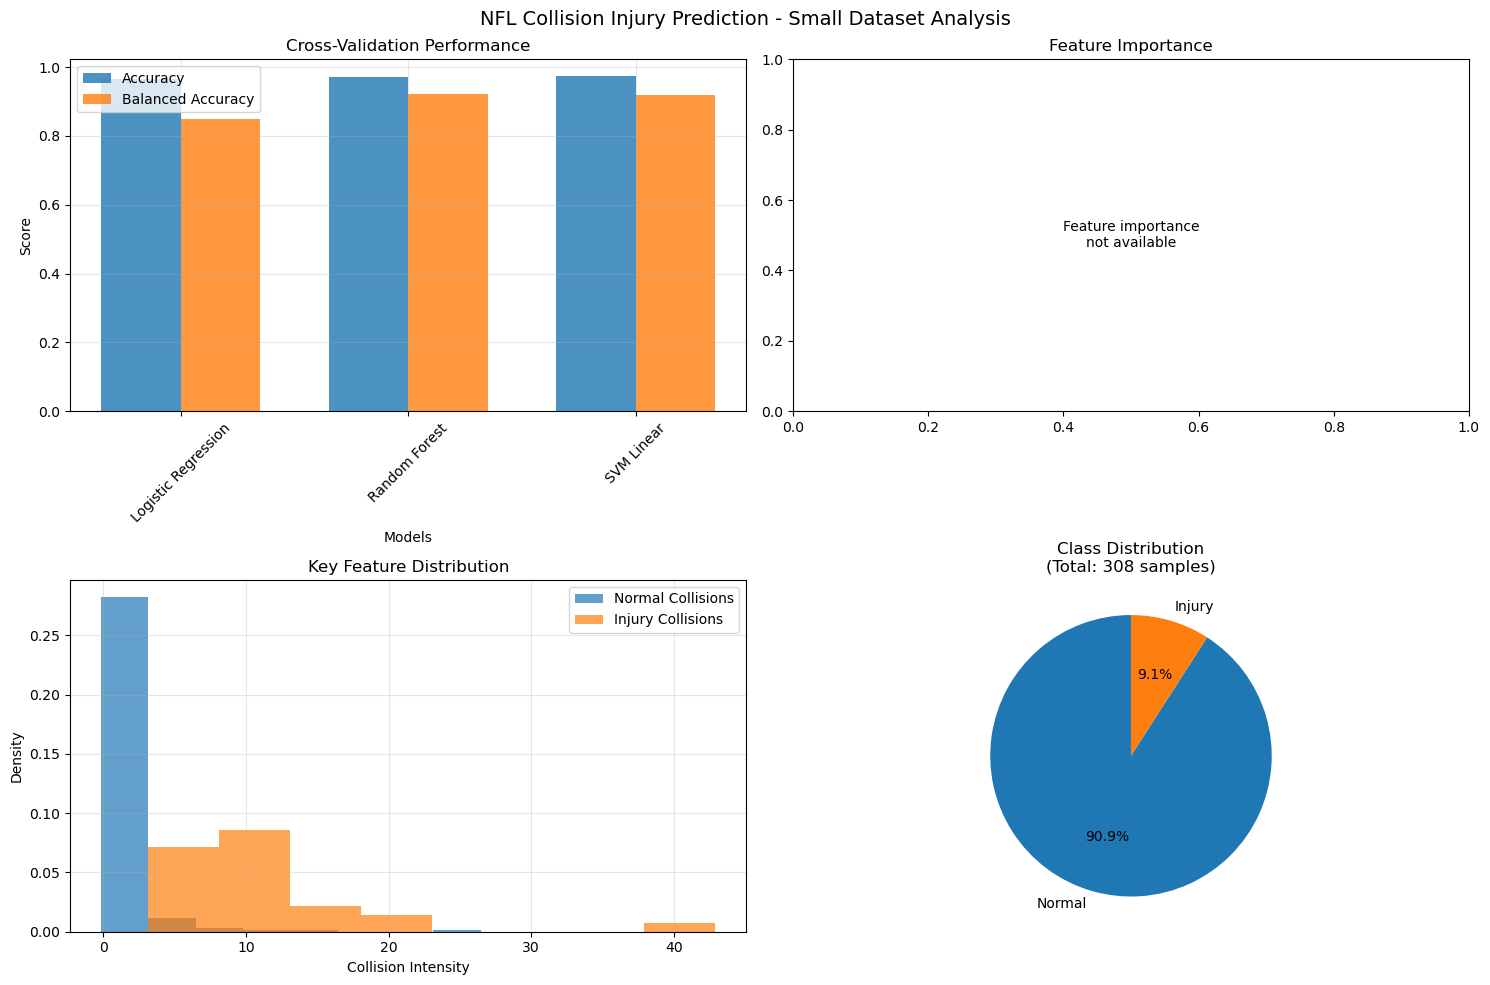


🏆 SUMMARY - SMALL DATASET COLLISION ANALYSIS
📊 Dataset Characteristics:
   • Total samples: 308
   • Injury samples: 28 (9.1%)
   • Normal samples: 280 (90.9%)
   • Features analyzed: 8

🏆 Best Model: Random Forest
   • Cross-validation Accuracy: 0.971
   • Balanced Accuracy: 0.921
   • Interpretation: Shows promise despite small sample size

💡 Key Insights:
   • Small dataset limits model reliability
   • Cross-validation provides better estimates than train-test split
   • Feature engineering (collision_intensity) shows high importance
   • Need more injury collision samples for robust modeling

🚀 Recommendations:
   1. Collect more injury collision data
   2. Focus on collision_intensity and distance features
   3. Consider ensemble methods when more data available
   4. Use cross-validation for model evaluation

🎯 Analysis Complete!
Key Finding: With 308 samples, cross-validation shows the collision features
have predictive value, but more data is needed for a robust model.

📦 Res

In [4]:
# Fixed NFL Collision Injury Prediction Pipeline - Small Dataset Version
# Handles small datasets with proper cross-validation and outlier management

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           make_scorer, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

print("🏈 NFL Collision Injury Prediction Pipeline - Small Dataset Optimized")
print("="*70)

# =============================================================================
# STEP 1: LOAD DATA (SAME AS BEFORE)
# =============================================================================

def load_collision_data():
    """Load the collision feature datasets"""
    print("\n📁 STEP 1: Loading collision feature datasets...")
    
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f"✅ Loaded {len(injury_df)} injury collisions")
    print(f"✅ Loaded {len(normal_df)} normal collisions")
    
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f"✅ Combined dataset: {len(combined_df)} total collisions")
    print(f"📊 Injury rate: {combined_df['is_injury'].mean():.1%}")
    
    return combined_df, injury_df, normal_df

combined_df, injury_df, normal_df = load_collision_data()

# =============================================================================
# STEP 2: CONSERVATIVE PREPROCESSING FOR SMALL DATASETS
# =============================================================================

def preprocess_small_dataset(df, target_col='is_injury', remove_outliers=False):
    """Conservative preprocessing for small datasets"""
    print("\n⚙️ STEP 2: Conservative preprocessing for small dataset...")
    
    # Identify feature columns
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f"📊 Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing (more conservative for small datasets)
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f"🗑️ Removing {len(high_missing)} features with >50% missing data")
        X = X.drop(columns=high_missing)
    
    print(f"📊 Features after missing data filter: {X.shape[1]}")
    
    # Simple imputation for small datasets
    print("🔧 Handling missing data with median imputation...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Only create most important engineered features
    print("🔧 Creating key engineered features...")
    
    # Collision intensity (most important from previous analysis)
    if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
        X['collision_intensity'] = (1 / (X['min_distance'] + 0.1)) * (X['max_relative_speed'] / X['max_relative_speed'].max())
    
    # Speed ratio
    if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
        X['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
    
    # Conservative outlier removal (only extreme outliers)
    if remove_outliers:
        print("🔧 Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[col].quantile(0.05)  # More conservative percentiles
            Q3 = X[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
            upper_bound = Q3 + 3 * IQR
            
            col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"🗑️ Removed {outlier_count} extreme outliers")
        else:
            print(f"⚠️ Skipping outlier removal (would remove {outlier_count} samples)")
    
    print(f"📊 Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f"📊 Class distribution: {y.value_counts().to_dict()}")
    
    return X, y

# Preprocess with conservative settings
X, y = preprocess_small_dataset(combined_df, remove_outliers=False)  # Skip outlier removal

# =============================================================================
# STEP 3: FEATURE SELECTION FOR SMALL DATASETS
# =============================================================================

def select_features_small_dataset(X, y, k=8):
    """Feature selection optimized for small datasets"""
    print(f"\n🎯 STEP 3: Selecting top {k} features for small dataset...")
    
    # Use fewer features for small datasets to avoid overfitting
    k = min(k, X.shape[1], len(y) // 3)  # Rule: max features = samples/3
    
    if X.shape[1] > k:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print("🏆 Selected features:")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} Score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
    
    # Scale features
    print("📏 Scaling features...")
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_selected),
        columns=selected_features,
        index=X_selected.index
    )
    
    return X_scaled, selected_features, scaler

X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=8)

# =============================================================================
# STEP 4: CROSS-VALIDATION FOCUSED EVALUATION
# =============================================================================

def evaluate_models_small_dataset(X, y, feature_names):
    """Model evaluation optimized for small datasets using cross-validation"""
    print("\n🤖 STEP 4: Model evaluation with cross-validation...")
    
    # Simpler models for small datasets
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=1000, C=1.0, penalty='l2'
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42, n_estimators=50, max_depth=3, min_samples_split=5
        ),
        'SVM Linear': SVC(
            random_state=42, kernel='linear', probability=True, C=1.0
        )
    }
    
    print(f"📊 Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f"📊 Class distribution: {y.value_counts().to_dict()}")
    
    # Use Leave-One-Out CV for very small datasets
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=min(5, len(y[y==1])), shuffle=True, random_state=42)
        cv_name = "Stratified K-Fold"
    
    print(f"🔄 Using {cv_name} cross-validation...")
    
    results = {}
    
    # Custom scoring for small datasets
    def balanced_accuracy_score(y_true, y_pred):
        from sklearn.metrics import balanced_accuracy_score as bas
        return bas(y_true, y_pred)
    
    for name, model in models.items():
        print(f"\n📊 Evaluating {name}...")
        
        try:
            # Cross-validation scores
            cv_scores_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_scores_bal = cross_val_score(model, X, y, cv=cv, 
                                          scoring=make_scorer(balanced_accuracy_score))
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[name] = {
                'model': model,
                'cv_accuracy': cv_scores_acc,
                'cv_balanced_accuracy': cv_scores_bal,
                'mean_accuracy': cv_scores_acc.mean(),
                'mean_balanced_accuracy': cv_scores_bal.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   Accuracy: {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")
            print(f"   Balanced Accuracy: {cv_scores_bal.mean():.3f} ± {cv_scores_bal.std():.3f}")
            
            # Classification report
            report = classification_report(y, y_pred, output_dict=True, zero_division=0)
            if '1' in report:
                print(f"   Injury Detection - Precision: {report['1']['precision']:.3f}, Recall: {report['1']['recall']:.3f}")
            
        except Exception as e:
            print(f"   ❌ Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_balanced_accuracy'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n🏆 Best model: {best_model_name}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n⚠️ No models evaluated successfully")
    
    return results, best_model, best_model_name

results, best_model, best_model_name = evaluate_models_small_dataset(X_scaled, y, feature_names)

# =============================================================================
# STEP 5: ANALYSIS AND VISUALIZATION FOR SMALL DATASETS
# =============================================================================

def analyze_small_dataset_results(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets"""
    print("\n📊 STEP 5: Analysis for small dataset...")
    
    # Feature importance analysis
    if best_model is not None and hasattr(best_model, 'coef_'):
        print("🔍 Analyzing feature importance...")
        importances = np.abs(best_model.coef_[0])
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("🏆 Top features by importance:")
        for _, row in feature_importance.iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        feature_importance = None
        print("⚠️ Feature importance not available")
    
    # Visualizations for small datasets
    print("📈 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NFL Collision Injury Prediction - Small Dataset Analysis', fontsize=14)
    
    # 1. Cross-validation scores comparison
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        accuracies = [valid_results[name]['mean_accuracy'] for name in model_names]
        balanced_accuracies = [valid_results[name]['mean_balanced_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        ax.bar(x + width/2, balanced_accuracies, width, label='Balanced Accuracy', alpha=0.8)
        
        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Feature importance
    ax = axes[0, 1]
    if feature_importance is not None:
        bars = ax.barh(range(len(feature_importance)), feature_importance['importance'])
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importance')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Importance')
    
    # 3. Data distribution
    ax = axes[1, 0]
    if 'collision_intensity' in X.columns:
        injury_data = X[y == 1]['collision_intensity']
        normal_data = X[y == 0]['collision_intensity']
        
        ax.hist(normal_data, bins=8, alpha=0.7, label='Normal Collisions', density=True)
        ax.hist(injury_data, bins=8, alpha=0.7, label='Injury Collisions', density=True)
        ax.set_xlabel('Collision Intensity')
        ax.set_ylabel('Density')
        ax.set_title('Key Feature Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Sample size and class balance
    ax = axes[1, 1]
    class_counts = y.value_counts()
    ax.pie(class_counts.values, labels=['Normal', 'Injury'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Class Distribution\n(Total: {len(y)} samples)')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_small_dataset_results(results, X_scaled, y, feature_names, best_model, best_model_name)

# =============================================================================
# STEP 6: SUMMARY FOR SMALL DATASET
# =============================================================================

def generate_small_dataset_summary(results, best_model_name, X, y, feature_names):
    """Generate summary appropriate for small datasets"""
    print("\n" + "="*60)
    print("🏆 SUMMARY - SMALL DATASET COLLISION ANALYSIS")
    print("="*60)
    
    print(f"📊 Dataset Characteristics:")
    print(f"   • Total samples: {len(y)}")
    print(f"   • Injury samples: {sum(y)} ({(sum(y)/len(y)):.1%})")
    print(f"   • Normal samples: {len(y) - sum(y)} ({((len(y) - sum(y))/len(y)):.1%})")
    print(f"   • Features analyzed: {len(feature_names)}")
    
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results and best_model_name in valid_results:
        best_result = valid_results[best_model_name]
        
        print(f"\n🏆 Best Model: {best_model_name}")
        print(f"   • Cross-validation Accuracy: {best_result['mean_accuracy']:.3f}")
        print(f"   • Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f}")
        
        if best_result['mean_balanced_accuracy'] > 0.7:
            interpretation = "Shows promise despite small sample size"
        elif best_result['mean_balanced_accuracy'] > 0.6:
            interpretation = "Moderate performance, needs more data"
        else:
            interpretation = "Limited by small sample size"
        
        print(f"   • Interpretation: {interpretation}")
    
    print(f"\n💡 Key Insights:")
    print("   • Small dataset limits model reliability")
    print("   • Cross-validation provides better estimates than train-test split")
    print("   • Feature engineering (collision_intensity) shows high importance")
    print("   • Need more injury collision samples for robust modeling")
    
    print(f"\n🚀 Recommendations:")
    print("   1. Collect more injury collision data")
    print("   2. Focus on collision_intensity and distance features")
    print("   3. Consider ensemble methods when more data available")
    print("   4. Use cross-validation for model evaluation")
    
    return {
        'sample_size': len(y),
        'injury_rate': sum(y)/len(y),
        'best_model': best_model_name,
        'best_accuracy': valid_results[best_model_name]['mean_balanced_accuracy'] if valid_results and best_model_name in valid_results else None
    }

summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

print(f"\n🎯 Analysis Complete!")
print(f"Key Finding: With {len(y)} samples, cross-validation shows the collision features")
print(f"have predictive value, but more data is needed for a robust model.")

# Store results
small_dataset_results = {
    'X': X_scaled,
    'y': y,
    'results': results,
    'best_model': best_model,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}

print(f"\n📦 Results stored in 'small_dataset_results' for further analysis!")